# Importing speech sentiments from Colab notebook

In [2]:
import pandas as pd
sentiments = pd.read_csv("src/Data/speech_all_finbert.csv").drop(columns=["Unnamed: 0"])
sentiments['info_channel'] = 'speech'
sentiments

,date,content,sentiment,probability,info_channel
0,1998-07-17,Mr. Duisenberg reports on the outcome of the s...,positive,0.854208,speech
1,1998-07-17,Economic growth has been driven increasingly b...,positive,0.947828,speech
2,1998-07-17,"In principle, the economic performance I have ...",neutral,0.600082,speech
3,1998-07-17,"Third, further structural adjustments in fisca...",neutral,0.824068,speech
4,1998-07-17,There is currently no sign of exchange rate te...,neutral,0.756298,speech
...,...,...,...,...,...
46014,2022-02-25,Since the exchange of confidential information...,positive,0.664321,speech
46015,2022-02-25,"Last year, following discussions in the Counci...",neutral,0.762738,speech
46016,2022-02-25,This type of measure has so far only been impl...,neutral,0.897179,speech
46017,2022-02-25,The ECB incorporated in its opinions its exper...,neutral,0.868921,speech


In [3]:
import pandas as pd

def generalize_sentiments(df):
    """
    Generalizes the sentiments of a dataframe by consolidating rows with the same date.
    It aggregates content by date, computes sentiment counts, and calculates max, min, and average 
    probabilities for each sentiment type (positive, negative, neutral).

    Parameters:
    - df (pandas.DataFrame): DataFrame containing 'date', 'content', 'sentiment', 
                             and respective sentiment probabilities columns.

    Returns:
    - pandas.DataFrame: DataFrame with consolidated content and aggregated sentiment metrics.
    """
    
    # Convert content to string to avoid TypeError and concatenate for rows with the same date
    consolidated_content = df.groupby('date')['content'].apply(lambda x: ' '.join(map(str, x))).reset_index()

    # Compute sentiment counts for each date
    sentiment_counts = df.groupby(['date', 'sentiment']).size().unstack().reset_index().fillna(0)
    sentiment_counts.columns = ['date'] + [f"{col.lower()}_counts" for col in sentiment_counts.columns if col != 'date']

    # Compute max, min, and average probabilities for each sentiment by date
    aggregations = {}
    for sentiment in ['positive', 'negative', 'neutral']:
        mask = df['sentiment'] == sentiment
        aggregated = df[mask].groupby('date').agg({
            'probability': ['max', 'min', 'mean']
        }).reset_index()
        
        # Flatten the multi-index column names
        aggregated.columns = ['date'] + [f"{sentiment}_{metric}" for metric in ['max', 'min', 'mean']]
        aggregations[sentiment] = aggregated

    # Merge the created dataframes to generate the final output
    result = consolidated_content
    result = pd.merge(result, sentiment_counts, on='date', how='inner')
    for sentiment in ['positive', 'negative', 'neutral']:
        result = pd.merge(result, aggregations[sentiment], on='date', how='inner')

    return result


In [4]:
gen_data = generalize_sentiments(sentiments)
gen_data['weighted_prob'] = (gen_data['negative_counts'] * gen_data['negative_mean'] * (-1) + gen_data['positive_counts'] * gen_data['positive_mean'] ) / (gen_data['negative_counts']+gen_data['positive_counts'])
gen_data['info_channel'] = 'speech'
gen_data.rename(columns={'date': 'Date'}, inplace=True)
gen_data

,Date,content,negative_counts,neutral_counts,positive_counts,positive_max,positive_min,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel
0,1998-11-09,Mr. Duisenberg’s opening statement at the pres...,6.0,13.0,2.0,0.899266,0.765561,0.832413,0.962060,0.523458,0.785708,0.948906,0.531514,0.870117,-0.381178,speech
1,1998-12-03,Mr Duisenberg reports on the current position ...,2.0,14.0,3.0,0.808924,0.565346,0.677796,0.847879,0.645703,0.746791,0.952718,0.680924,0.828251,0.107961,speech
2,1999-01-08,Mr Duisenberg’s opening statement at the press...,2.0,18.0,2.0,0.923603,0.554621,0.739112,0.947072,0.880715,0.913893,0.949159,0.535464,0.845749,-0.087391,speech
3,1999-01-11,Mr Duisenberg’s opening statement at the press...,10.0,23.0,2.0,0.817296,0.668759,0.743027,0.954375,0.496729,0.723577,0.950720,0.375282,0.818889,-0.479143,speech
4,1999-01-19,Mr Duisenberg’s opening statement at the Europ...,6.0,16.0,2.0,0.870406,0.866672,0.868539,0.968294,0.739333,0.871450,0.946656,0.559591,0.827322,-0.436452,speech
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2022-01-21,Christine Lagarde: Introductory statement at t...,1.0,7.0,10.0,0.953582,0.613189,0.747925,0.466378,0.466378,0.466378,0.839482,0.542453,0.744504,0.637534,speech
1248,2022-02-04,Christine Lagarde: Introductory statement at E...,4.0,1.0,4.0,0.954398,0.446699,0.824757,0.943139,0.491753,0.756767,0.539072,0.539072,0.539072,0.033995,speech
1249,2022-02-10,Christine Lagarde: Hearing of the Committee on...,4.0,5.0,3.0,0.953364,0.543439,0.779126,0.943748,0.461614,0.703850,0.872223,0.506347,0.692795,-0.068289,speech
1250,2022-02-17,Christine Lagarde: Introductory statement - Eu...,3.0,8.0,5.0,0.946285,0.534803,0.763456,0.928384,0.727196,0.845817,0.895302,0.626179,0.816141,0.159978,speech


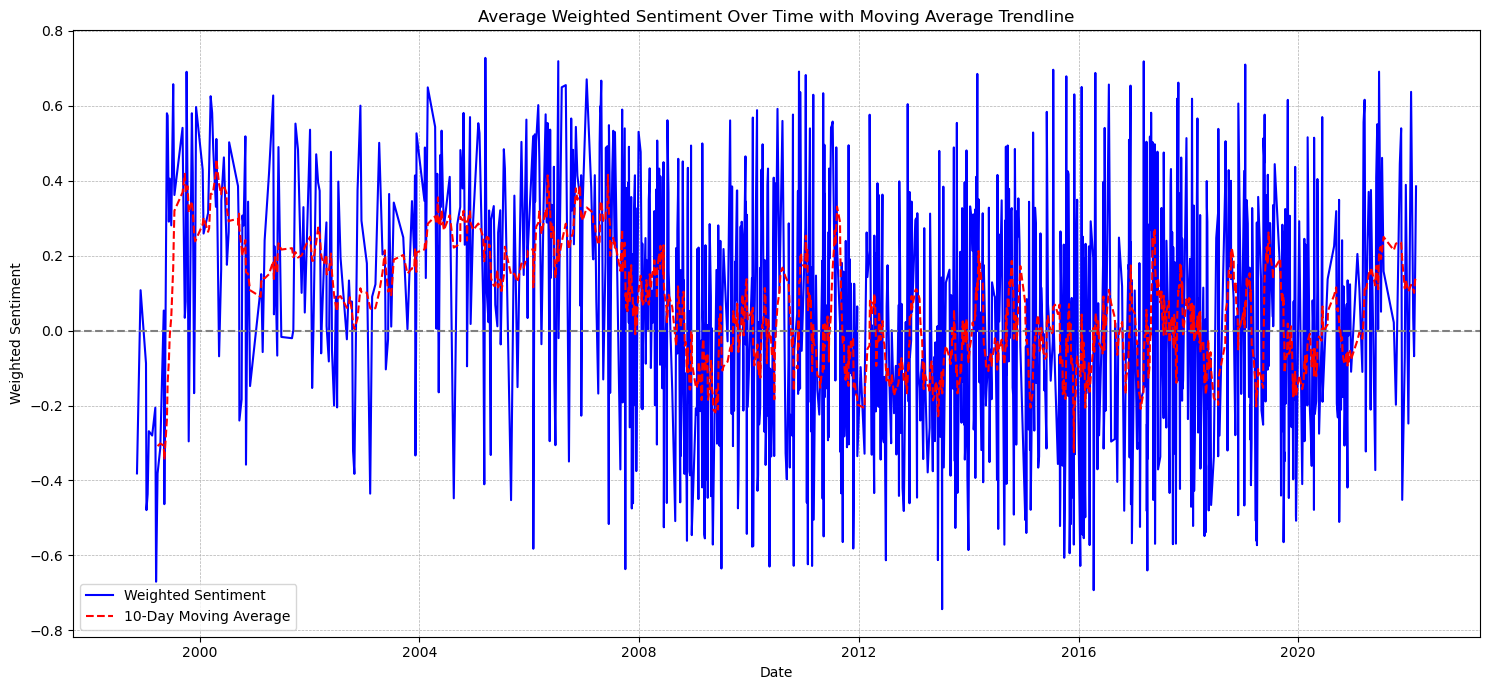

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Assuming gen_data is your dataframe
# Convert the date column to datetime type for better plotting
gen_data['Date'] = pd.to_datetime(gen_data['Date'])

# Calculate the moving average. Adjust the window size as needed.
window_size = 10  # Adjust this as per your preference
gen_data['moving_avg_sentiment'] = gen_data['weighted_prob'].rolling(window=window_size).mean()

# Plotting
plt.figure(figsize=(15,7))
plt.plot(gen_data['Date'], gen_data['weighted_prob'], label='Weighted Sentiment', color='blue')
plt.plot(gen_data['Date'], gen_data['moving_avg_sentiment'], "r--", label=f'{window_size}-Day Moving Average')
plt.axhline(y=0, color='grey', linestyle='--')  # A line at y=0 for reference

plt.title('Average Weighted Sentiment Over Time with Moving Average Trendline')
plt.xlabel('Date')
plt.ylabel('Weighted Sentiment')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Bring other time series variables

In [6]:
import yfinance as yf
import pandas as pd

# Define the path to your data file
data_path = "src/Data/stoxx.txt"

# Read the data file into a DataFrame
vstoxx_df = pd.read_csv(data_path, delimiter=";", parse_dates=["Date"], dayfirst=True)

# Change the date format to DD-MM-YYYY
vstoxx_df["Date_merge"] = vstoxx_df["Date"].dt.strftime("%d-%m-%Y")

# generate day of the week column
vstoxx_df['day_of_week'] = pd.to_datetime(vstoxx_df['Date']).dt.day_name()

# generate month column
vstoxx_df['month'] = pd.to_datetime(vstoxx_df['Date']).dt.month_name()

# calculate the daily change in the index
vstoxx_df['vstoxx_delta_daily'] = vstoxx_df['Indexvalue'].diff()
#vstoxx_df['delta_3d'] = vstoxx_df['Indexvalue'].diff(3)
#vstoxx_df['delta_5d'] = vstoxx_df['Indexvalue'].diff(5)
#vstoxx_df['delta_30d'] = vstoxx_df['Indexvalue'].diff(30)
#vstoxx_df['3d_pp_change'] = vstoxx_df['Indexvalue'].pct_change(3)
vstoxx_df['vstoxx_shifted_1_day'] = vstoxx_df['Indexvalue'].shift(-2)
vstoxx_df['vstoxx_delta_shifted'] = vstoxx_df['Indexvalue'] - vstoxx_df['vstoxx_shifted_1_day']
vstoxx_df['vstoxx_delta_shifted_2'] = vstoxx_df['vstoxx_delta_shifted'].shift(1)
# Display the DataFrame
vstoxx_df


,Date,Symbol,Indexvalue,Date_merge,day_of_week,month,vstoxx_delta_daily,vstoxx_shifted_1_day,vstoxx_delta_shifted,vstoxx_delta_shifted_2
0,1999-01-04,V2TX,18.2033,04-01-1999,Monday,January,NaN,25.1670,-6.9637,NaN
1,1999-01-05,V2TX,29.6912,05-01-1999,Tuesday,January,11.4879,32.5205,-2.8293,-6.9637
2,1999-01-06,V2TX,25.1670,06-01-1999,Wednesday,January,-4.5242,33.2296,-8.0626,-2.8293
3,1999-01-07,V2TX,32.5205,07-01-1999,Thursday,January,7.3535,36.8411,-4.3206,-8.0626
4,1999-01-08,V2TX,33.2296,08-01-1999,Friday,January,0.7091,37.5664,-4.3368,-4.3206
...,...,...,...,...,...,...,...,...,...,...
6268,2023-08-15,V2TX,18.8579,15-08-2023,Tuesday,August,0.8050,20.3539,-1.4960,-0.4981
6269,2023-08-16,V2TX,18.5510,16-08-2023,Wednesday,August,-0.3069,20.2456,-1.6946,-1.4960
6270,2023-08-17,V2TX,20.3539,17-08-2023,Thursday,August,1.8029,19.8367,0.5172,-1.6946
6271,2023-08-18,V2TX,20.2456,18-08-2023,Friday,August,-0.1083,NaN,NaN,0.5172


# Bond price data

In [7]:
bond_data = pd.read_csv("src/Data/10_year_maturity.csv")
# change variable names to Date and 10_y_bond_yield
bond_data.columns = ['Date', 'Date_2', '10_y_bond_yield']
# drop the second date column
bond_data = bond_data.drop(columns=['Date_2'])
bond_data['Date'] = pd.to_datetime(bond_data['Date'])
bond_data

,Date,10_y_bond_yield
0,2004-09-06,4.209220
1,2004-09-07,4.209626
2,2004-09-08,4.228419
3,2004-09-09,4.161872
4,2004-09-10,4.120981
...,...,...
4867,2023-09-15,2.734948
4868,2023-09-18,2.788173
4869,2023-09-19,2.807675
4870,2023-09-20,2.765770


In [8]:
# import the yield curve data
yield_curve = pd.read_csv("src/Data/euro_yield_curve.csv")

# Select only 'date' and 's1' columns
yield_curve = yield_curve[['date', 's1']]

# Rename the 's1' column to 's1_yield'
yield_curve.rename(columns={'s1': 'euro_yield'}, inplace=True)
yield_curve.rename(columns={'date': 'Date'}, inplace=True)


yield_curve 

,Date,euro_yield
0,2004-09-06,3.298175
1,2004-09-07,3.338711
2,2004-09-08,3.375993
3,2004-09-09,3.284360
4,2004-09-10,3.208441
...,...,...
4843,2023-08-14,2.370727
4844,2023-08-15,2.448853
4845,2023-08-16,2.428063
4846,2023-08-17,2.466451


In [9]:
ref_rate = pd.read_csv("src/Data/main_ref_rate.csv")
# keep only date, s3, s8 and s10
ref_rate = ref_rate[['date', 's3', 's8', 's10']]
# input the last value to the NaNs
ref_rate['s3'] = ref_rate['s3'].fillna(method='ffill')
# remove the NaNs
ref_rate = ref_rate.dropna()
# transform 1998-12-31 24:00:00 to 1999-01-01 00:00:00 format in date column
ref_rate['Date'] = ref_rate['date'].str.replace(' 24:00:00', ' 00:00:00')
# convert date to datetime format

ref_rate['Date'] = pd.to_datetime(ref_rate['Date'])
ref_rate.drop(columns=['date'], inplace=True)
ref_rate


,s3,s8,s10,Date
3,-1.25,0.75,-1.25,1999-01-03
4,-1.25,0.75,-1.25,1999-01-04
5,-1.25,0.75,-1.25,1999-01-05
6,-1.25,0.75,-1.25,1999-01-06
7,-1.25,0.75,-1.25,1999-01-07
...,...,...,...,...
9005,0.25,0.25,0.25,2023-08-27
9006,0.25,0.25,0.25,2023-08-28
9007,0.25,0.25,0.25,2023-08-29
9008,0.25,0.25,0.25,2023-08-30


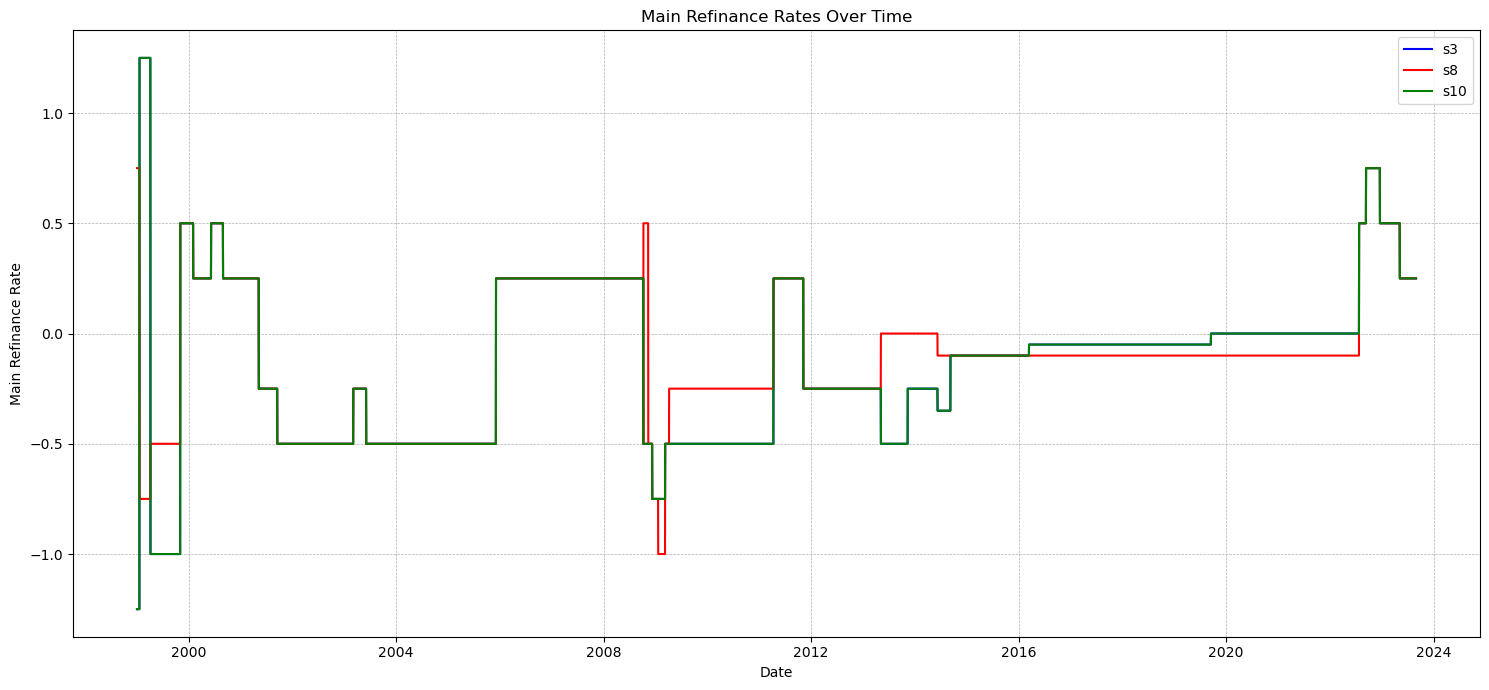

In [10]:
# plot s3, s8 and s10 rates over time
plt.figure(figsize=(15,7))
plt.plot(ref_rate['Date'], ref_rate['s3'], label='s3', color='blue')
plt.plot(ref_rate['Date'], ref_rate['s8'], label='s8', color='red')
plt.plot(ref_rate['Date'], ref_rate['s10'], label='s10', color='green')
plt.title('Main Refinance Rates Over Time')
plt.xlabel('Date')
plt.ylabel('Main Refinance Rate')
plt.legend()
plt.tight_layout()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


# Labor and unemployment data

In [11]:
# import and transform the data for labor productivity
labor = pd.read_csv("src/Data/Labor_productivity.csv")

# import and transform the data for unemployment
unemployment = pd.read_csv("src/Data/Unemployment.csv")

In [12]:
unemployment

,date,conf,status1,s1
0,2000-01-30 24:00:00,NaN,Normal value,9.44
1,2000-02-28 24:00:00,NaN,Normal value,9.35
2,2000-03-30 24:00:00,NaN,Normal value,9.26
3,2000-04-29 24:00:00,NaN,Normal value,9.18
4,2000-05-30 24:00:00,NaN,Normal value,9.12
...,...,...,...,...
277,2023-02-27 24:00:00,NaN,Normal value,6.59
278,2023-03-30 24:00:00,NaN,Normal value,6.52
279,2023-04-29 24:00:00,NaN,Normal value,6.45
280,2023-05-30 24:00:00,NaN,Normal value,6.40


In [13]:
# Adjust the time and increment the date
def adjust_time(date_string):
    if '24:00:00' in date_string:
        date_string = date_string.replace('24:00:00', '00:00:00')
        date_object = pd.to_datetime(date_string) + pd.Timedelta(days=1)
        return date_object.date()
    else:
        return pd.to_datetime(date_string).date()

labor['Date'] = labor['date'].apply(adjust_time)
unemployment['Date'] = unemployment['date'].apply(adjust_time)

In [14]:
import pandas as pd

# Sample data loading (you might have your own way of reading these dataframes)
# labor = pd.read_csv("path_to_labor.csv")
# unemployment = pd.read_csv("path_to_unemployment.csv")

# Merge the dataframes using an outer join
labor_unemployment = pd.merge(labor[['Date', 's1']], 
                              unemployment[['date', 's1']], 
                              left_on='Date', 
                              right_on='date', 
                              how='outer', 
                              suffixes=('_labor', '_unemployment'))

# Drop redundant date column
labor_unemployment.drop(columns=['Date'], inplace=True)

# Rename columns for clarity
labor_unemployment.rename(columns={
    'date': 'Date',
    's1_labor': 'labor_prod_s1', 
    's1_unemployment': 'unemployment_s1'
}, inplace=True)

# Handle missing values by forward filling
labor_unemployment['labor_prod_s1'] = labor_unemployment['labor_prod_s1'].fillna(method='ffill')
labor_unemployment['unemployment_s1'] = labor_unemployment['unemployment_s1'].fillna(method='ffill')

# Display the merged dataframe
labor_unemployment

,labor_prod_s1,Date,unemployment_s1
0,0.22,NaN,NaN
1,0.38,NaN,NaN
2,1.01,NaN,NaN
3,2.01,NaN,NaN
4,1.96,NaN,NaN
...,...,...,...
375,-0.77,2023-02-27 24:00:00,6.59
376,-0.77,2023-03-30 24:00:00,6.52
377,-0.77,2023-04-29 24:00:00,6.45
378,-0.77,2023-05-30 24:00:00,6.40


# Dax data

In [15]:
dax_selected = pd.read_csv("src/Data/^GDAXI.csv")

# keep only date, close and volume
dax_selected = dax_selected[['Date', 'Close', 'Volume']]
dax_selected.rename(columns={'Close': 'Close_dax', 'Volume':'Volume_dax'}, inplace=True)
dax_selected

,Date,Close_dax,Volume_dax
0,2000-01-03,6750.759766,43072500.0
1,2000-01-04,6586.950195,46678400.0
2,2000-01-05,6502.069824,52682800.0
3,2000-01-06,6474.919922,41180600.0
4,2000-01-07,6780.959961,56058900.0
...,...,...,...
6064,2023-09-18,15727.120117,58899600.0
6065,2023-09-19,15664.480469,53581800.0
6066,2023-09-20,15781.589844,54733100.0
6067,2023-09-21,15571.860352,65995100.0


In [16]:
# import volatility data
volatility = pd.read_csv("src/Data/^EVZ volatility.csv")
# keep only date and close
volatility = volatility[['Date', 'Close']]
# rename close to close_volatility
volatility.rename(columns={'Close': 'Close_volatility'}, inplace=True)
volatility

,Date,Close_volatility
0,2008-09-25,14.420000
1,2008-09-26,14.990000
2,2008-09-29,15.320000
3,2008-09-30,18.719999
4,2008-10-01,17.280001
...,...,...
3769,2023-09-18,6.750000
3770,2023-09-19,6.920000
3771,2023-09-20,6.800000
3772,2023-09-21,7.250000


# Merge all of them into one


In [17]:
dfs = [gen_data, vstoxx_df, bond_data, yield_curve, ref_rate, labor_unemployment, dax_selected, volatility]
# Ensure 'Date' columns of all dataframes are corrected and of type datetime64[ns]
for df in dfs:
    # Convert 'Date' column to string for string operations
    df['Date'] = df['Date'].astype(str)
    
    # Replace '24:00:00' with '00:00:00' and add a day
    mask = df['Date'].str.contains('24:00:00', na=False)
    df.loc[mask, 'Date'] = pd.to_datetime(df['Date'].str.replace('24:00:00', '00:00:00')) + pd.Timedelta(days=1)
    
    # Convert to datetime format
    df['Date'] = pd.to_datetime(df['Date'])

# Initialize 'merged_df' with the first dataframe
merged_df = dfs[0].copy()

# Iteratively merge the other dataframes
for i, df in enumerate(dfs[1:], 2):  # Start enumeration at 2 for suffix purposes
    # Find overlapping columns (other than 'Date')
    overlapping_columns = df.columns[df.columns.isin(merged_df.columns) & (df.columns != 'Date')]
    
    # For overlapping columns in the next dataframe, add suffixes
    df = df.rename(columns={col: f"{col}_df{i}" for col in overlapping_columns})
    
    # Merge
    merged_df = merged_df.merge(df, on='Date', how='outer')

# Display the merged dataframe
merged_df
# print(merged_df.shape)


,Date,content,negative_counts,neutral_counts,positive_counts,positive_max,positive_min,positive_mean,negative_max,negative_min,...,10_y_bond_yield,euro_yield,s3,s8,s10,labor_prod_s1,unemployment_s1,Close_dax,Volume_dax,Close_volatility
0,1998-11-09,Mr. Duisenberg’s opening statement at the pres...,6.0,13.0,2.0,0.899266,0.765561,0.832413,0.962060,0.523458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-12-03,Mr Duisenberg reports on the current position ...,2.0,14.0,3.0,0.808924,0.565346,0.677796,0.847879,0.645703,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1999-01-08,Mr Duisenberg’s opening statement at the press...,2.0,18.0,2.0,0.923603,0.554621,0.739112,0.947072,0.880715,...,NaN,NaN,-1.25,0.75,-1.25,NaN,NaN,NaN,NaN,NaN
3,1999-01-11,Mr Duisenberg’s opening statement at the press...,10.0,23.0,2.0,0.817296,0.668759,0.743027,0.954375,0.496729,...,NaN,NaN,-1.25,0.75,-1.25,NaN,NaN,NaN,NaN,NaN
4,1999-01-19,Mr Duisenberg’s opening statement at the Europ...,6.0,16.0,2.0,0.870406,0.866672,0.868539,0.968294,0.739333,...,NaN,NaN,-1.25,0.75,-1.25,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9118,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.52,NaN,NaN,NaN,NaN
9119,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.19,NaN,NaN,NaN,NaN
9120,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.47,NaN,NaN,NaN,NaN
9121,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.77,NaN,NaN,NaN,NaN


In [18]:
# List of columns to shift
columns_to_shift = ['Indexvalue', '10_y_bond_yield', 'euro_yield', 'moving_avg_sentiment','Close_dax']

# Shift and create new columns for the different lags
for col in columns_to_shift:
    for lag in [1, 3, 7]:
        new_col_name = f"{col}_{lag}_day"
        merged_df[new_col_name] = merged_df[col].shift(lag)

print(merged_df)

           Date                                            content  \
0    1998-11-09  Mr. Duisenberg’s opening statement at the pres...   
1    1998-12-03  Mr Duisenberg reports on the current position ...   
2    1999-01-08  Mr Duisenberg’s opening statement at the press...   
3    1999-01-11  Mr Duisenberg’s opening statement at the press...   
4    1999-01-19  Mr Duisenberg’s opening statement at the Europ...   
...         ...                                                ...   
9118        NaT                                                NaN   
9119        NaT                                                NaN   
9120        NaT                                                NaN   
9121        NaT                                                NaN   
9122 2023-09-22                                                NaN   

      negative_counts  neutral_counts  positive_counts  positive_max  \
0                 6.0            13.0              2.0      0.899266   
1              

In [19]:
merged_df.columns.tolist()


['Date',
 'content',
 'negative_counts',
 'neutral_counts',
 'positive_counts',
 'positive_max',
 'positive_min',
 'positive_mean',
 'negative_max',
 'negative_min',
 'negative_mean',
 'neutral_max',
 'neutral_min',
 'neutral_mean',
 'weighted_prob',
 'info_channel',
 'moving_avg_sentiment',
 'Symbol',
 'Indexvalue',
 'Date_merge',
 'day_of_week',
 'month',
 'vstoxx_delta_daily',
 'vstoxx_shifted_1_day',
 'vstoxx_delta_shifted',
 'vstoxx_delta_shifted_2',
 '10_y_bond_yield',
 'euro_yield',
 's3',
 's8',
 's10',
 'labor_prod_s1',
 'unemployment_s1',
 'Close_dax',
 'Volume_dax',
 'Close_volatility',
 'Indexvalue_1_day',
 'Indexvalue_3_day',
 'Indexvalue_7_day',
 '10_y_bond_yield_1_day',
 '10_y_bond_yield_3_day',
 '10_y_bond_yield_7_day',
 'euro_yield_1_day',
 'euro_yield_3_day',
 'euro_yield_7_day',
 'moving_avg_sentiment_1_day',
 'moving_avg_sentiment_3_day',
 'moving_avg_sentiment_7_day',
 'Close_dax_1_day',
 'Close_dax_3_day',
 'Close_dax_7_day']

In [20]:
# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

print(nan_table)


                            NaN/Null Count
Date                                    98
content                               7871
negative_counts                       7871
neutral_counts                        7871
positive_counts                       7871
positive_max                          7871
positive_min                          7871
positive_mean                         7871
negative_max                          7871
negative_min                          7871
negative_mean                         7871
neutral_max                           7871
neutral_min                           7871
neutral_mean                          7871
weighted_prob                         7871
info_channel                          7871
moving_avg_sentiment                  7880
Symbol                                2850
Indexvalue                            2850
Date_merge                            2850
day_of_week                           2850
month                                 2850
vstoxx_delt

In [21]:
"""
columns_to_fill = [
    'Close_dax',
    'Volume_dax',
    'Close_vdax',
    'Volume_vdax',
    'labor_prod_s1',
    'unemployment_s1',
    's1_yield',
    'bond_price',
    'b_delta_daily',
    'Indexvalue'
]

for column in columns_to_fill:
    merged_df[column] = merged_df[column].fillna(method='ffill')

merged_df
"""

"\ncolumns_to_fill = [\n    'Close_dax',\n    'Volume_dax',\n    'Close_vdax',\n    'Volume_vdax',\n    'labor_prod_s1',\n    'unemployment_s1',\n    's1_yield',\n    'bond_price',\n    'b_delta_daily',\n    'Indexvalue'\n]\n\nfor column in columns_to_fill:\n    merged_df[column] = merged_df[column].fillna(method='ffill')\n\nmerged_df\n"

In [22]:
# Filter the rows based on the 'Date' column
merged_df = merged_df[merged_df['Date'] > '2005-01-01']

# filter and keep only where weighted_prob	exists
merged_df = merged_df[merged_df['weighted_prob'].notna()]

# Count NaN and null values for each column
nan_counts = merged_df.isna().sum()

# Convert to DataFrame for better presentation
nan_table = pd.DataFrame(nan_counts, columns=['NaN/Null Count'])

nan_table


,NaN/Null Count
Date,0
content,0
negative_counts,0
neutral_counts,0
positive_counts,0
positive_max,0
positive_min,0
positive_mean,0
negative_max,0
negative_min,0


In [23]:
# display dataframe with all the columns 
pd.set_option('display.max_columns', None)
merged_df['labor_prod_s1'] = merged_df['labor_prod_s1'].fillna(method='ffill')
merged_df['unemployment_s1'] = merged_df['unemployment_s1'].fillna(method='ffill')

# for all previous rows of labor and unemployment, fill NaNs with 0
merged_df['labor_prod_s1'] = merged_df['labor_prod_s1'].fillna(0)
merged_df['unemployment_s1'] = merged_df['unemployment_s1'].fillna(0)

# fill NaNs with its previous value in Close_volatility column
merged_df['Close_volatility'] = merged_df['Close_volatility'].fillna(method='ffill')
# fill initial NaNs with 0
merged_df['Close_volatility'] = merged_df['Close_volatility'].fillna(0)

merged_df

,Date,content,negative_counts,neutral_counts,positive_counts,positive_max,positive_min,positive_mean,negative_max,negative_min,negative_mean,neutral_max,neutral_min,neutral_mean,weighted_prob,info_channel,moving_avg_sentiment,Symbol,Indexvalue,Date_merge,day_of_week,month,vstoxx_delta_daily,vstoxx_shifted_1_day,vstoxx_delta_shifted,vstoxx_delta_shifted_2,10_y_bond_yield,euro_yield,s3,s8,s10,labor_prod_s1,unemployment_s1,Close_dax,Volume_dax,Close_volatility,Indexvalue_1_day,Indexvalue_3_day,Indexvalue_7_day,10_y_bond_yield_1_day,10_y_bond_yield_3_day,10_y_bond_yield_7_day,euro_yield_1_day,euro_yield_3_day,euro_yield_7_day,moving_avg_sentiment_1_day,moving_avg_sentiment_3_day,moving_avg_sentiment_7_day,Close_dax_1_day,Close_dax_3_day,Close_dax_7_day
159,2005-01-26,Jean-Claude Trichet: The euro - successes and ...,1.0,10.0,8.0,0.882642,0.466327,0.687462,0.515659,0.515659,0.515659,0.927084,0.479027,0.698223,0.553782,speech,0.285913,V2TX,13.3240,26-01-2005,Wednesday,January,-0.3040,12.8050,0.5190,1.1660,3.573076,2.802277,-0.5,-0.5,-0.5,0.00,0.00,4214.120117,141212200.0,0.00,12.9441,15.6704,17.5673,3.613551,3.828690,3.994896,2.795959,2.838865,2.994235,0.268492,0.318506,0.290772,4251.620117,4216.399902,3959.590088
160,2005-02-03,Jean-Claude Trichet: Interview with Les Echos ...,1.0,39.0,9.0,0.807713,0.362695,0.646132,0.540062,0.540062,0.540062,0.944788,0.507110,0.804610,0.527512,speech,0.280547,V2TX,12.3844,03-02-2005,Thursday,February,0.1339,11.9934,0.3910,0.6539,3.554661,2.841413,-0.5,-0.5,-0.5,0.00,0.00,4281.640137,96153600.0,0.00,13.3240,15.7266,14.6206,3.573076,3.750883,3.930825,2.802277,2.725730,2.930737,0.285913,0.287260,0.291104,4214.120117,4193.910156,4089.129883
161,2005-02-28,Jean-Claude Trichet: Monetary policy and priva...,4.0,33.0,5.0,0.794457,0.461968,0.668889,0.808487,0.560649,0.681837,0.940553,0.521477,0.827575,0.068567,speech,0.249022,V2TX,12.8907,28-02-2005,Monday,February,0.6800,12.8591,0.0316,-0.1395,3.710944,2.970440,-0.5,-0.5,-0.5,-0.77,9.29,4350.490234,110897300.0,0.00,12.3844,12.9441,14.3737,3.554661,3.613551,3.887884,2.841413,2.795959,2.863330,0.280547,0.268492,0.240526,4281.640137,4251.620117,4143.350098
162,2005-03-07,European Central Bank: Press conference - intr...,5.0,4.0,2.0,0.740040,0.507554,0.623797,0.973803,0.643690,0.823827,0.768903,0.595795,0.651477,-0.410220,speech,0.185070,V2TX,11.7178,07-03-2005,Monday,March,-0.2132,12.5319,-0.8141,-0.0710,3.681450,2.862540,-0.5,-0.5,-0.5,-0.77,9.29,4428.089844,81185200.0,0.00,12.8907,13.3240,14.9812,3.710944,3.573076,3.853985,2.970440,2.802277,2.834914,0.249022,0.285913,0.289799,4350.490234,4214.120117,4134.339844
163,2005-03-14,Jean-Claude Trichet: Economic and financial in...,1.0,22.0,14.0,0.952844,0.511849,0.819305,0.547662,0.547662,0.547662,0.926835,0.487195,0.756132,0.728174,speech,0.230004,V2TX,13.3498,14-03-2005,Monday,March,0.3932,14.5708,-1.2210,0.4620,3.794177,2.946157,-0.5,-0.5,-0.5,-0.77,9.29,4367.299805,69258200.0,0.00,11.7178,12.3844,15.6704,3.681450,3.554661,3.828690,2.862540,2.841413,2.838865,0.185070,0.280547,0.318506,4428.089844,4281.640137,4216.399902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1247,2022-01-21,Christine Lagarde: Introductory statement at t...,1.0,7.0,10.0,0.953582,0.613189,0.747925,0.466378,0.466378,0.466378,0.839482,0.542453,0.744504,0.637534,speech,0.122252,V2TX,24.2217,21-01-2022,Friday,January,3.8184,31.4530,-7.2313,-12.2778,-0.079525,-0.500242,0.0,-0.1,0.0,-0.77,8.56,15603.879883,105899500.0,5.92,19.1696,22.4272,20.7442,-0.123137,-0.340218,-0.084251,-0.549393,-0.675031,-0.615984,0.104626,0.113040,0.232327,16020.730469,15623.309570,15146.870117
1248,2022-02-04,Christine Lagarde: Introductory statement at E...,4.0,1.0,4.0,0.954398,0.446699,0.824757,0.943139,0.491753,0.756767,0.539072,0.539072,0.539072,0.033995,speech,0.109810,V2TX,26.3008,04-02-2022,Friday,Feb

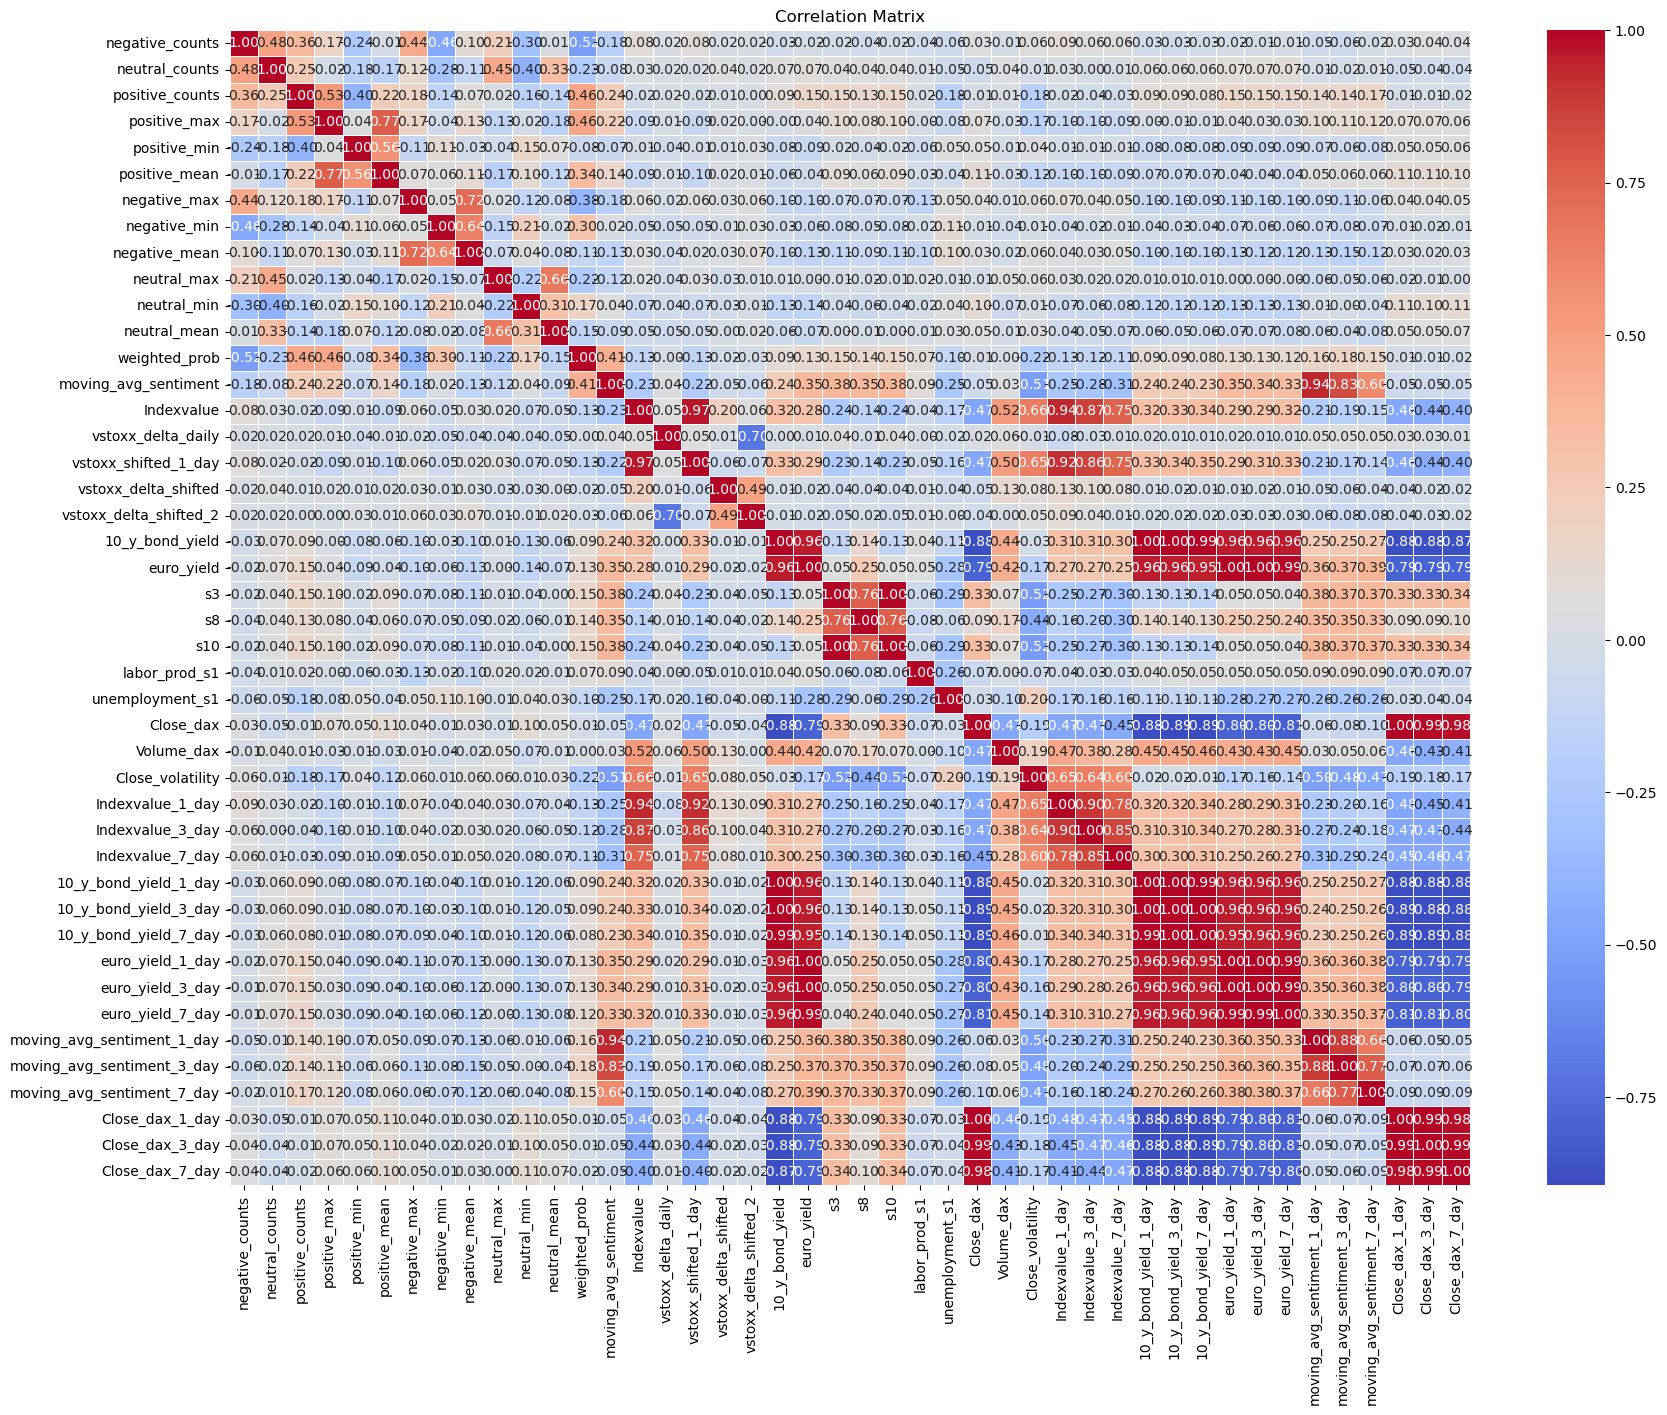

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

# Keep only numeric columns
numeric_cols = merged_df.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_cols.corr()

# Plot the heatmap
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5, fmt='.2f')
plt.title('Correlation Matrix')
plt.show()


In [25]:
# Compute correlations of each column against 'weighted_prob'
correlations = {}
for col in merged_df.columns:
    if merged_df[col].dtype in ['float64', 'int64'] and col != 'weighted_prob':
        correlations[col] = merged_df[col].corr(merged_df['weighted_prob'])

# Convert dictionary to a DataFrame for better visualization and sorting
correlation_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'Correlation_with_weighted_prob'])

# Sort by the absolute value of correlation to get a ranking
correlation_df['Abs_Correlation'] = correlation_df['Correlation_with_weighted_prob'].abs()
correlation_df = correlation_df.sort_values(by='Abs_Correlation', ascending=False).drop('Abs_Correlation', axis=1)

# Display the ranked correlations
print(correlation_df)


                      Variable  Correlation_with_weighted_prob
0              negative_counts                       -0.518381
2              positive_counts                        0.462270
3                 positive_max                        0.461506
12        moving_avg_sentiment                        0.409274
6                 negative_max                       -0.380445
5                positive_mean                        0.344238
7                 negative_min                        0.297973
1               neutral_counts                       -0.226888
9                  neutral_max                       -0.224788
27            Close_volatility                       -0.223324
38  moving_avg_sentiment_3_day                        0.177889
10                 neutral_min                        0.167157
37  moving_avg_sentiment_1_day                        0.163755
39  moving_avg_sentiment_7_day                        0.152950
20                          s3                        0

# LSTM model with proper data preprocessing

In [123]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract data
features = merged_df[['Date','Indexvalue','10_y_bond_yield', 'vstoxx_shifted_1_day', 'day_of_week', 's10',
                       'labor_prod_s1', 'unemployment_s1','Close_dax_1_day','euro_yield_1_day' ]]

features = features[features['day_of_week'].notna()]

features['Close_dax_1_day'] = features['Close_dax_1_day'].fillna(method='ffill')
#features['Volume_dax'] = features['Volume_dax'].fillna(method='ffill')

# count nans
features.isnull().sum()
# reset index
features = features.reset_index(drop=True)



In [124]:
# store the dates for later visualization 
dates_series = features['Date']
features


,Date,Indexvalue,10_y_bond_yield,vstoxx_shifted_1_day,day_of_week,s10,labor_prod_s1,unemployment_s1,Close_dax_1_day,euro_yield_1_day
0,2005-01-26,13.3240,3.573076,12.8050,Wednesday,-0.5,0.00,0.00,4251.620117,2.795959
1,2005-02-03,12.3844,3.554661,11.9934,Thursday,-0.5,0.00,0.00,4214.120117,2.802277
2,2005-02-28,12.8907,3.710944,12.8591,Monday,-0.5,-0.77,9.29,4281.640137,2.841413
3,2005-03-07,11.7178,3.681450,12.5319,Monday,-0.5,-0.77,9.29,4350.490234,2.970440
4,2005-03-14,13.3498,3.794177,14.5708,Monday,-0.5,-0.77,9.29,4428.089844,2.862540
...,...,...,...,...,...,...,...,...,...,...
1086,2022-01-21,24.2217,-0.079525,31.4530,Friday,0.0,-0.77,8.56,16020.730469,-0.549393
1087,2022-02-04,26.3008,0.195480,23.1564,Friday,0.0,-0.77,8.56,15603.879883,-0.500242
1088,2022-02-10,21.8414,0.281690,30.0547,Thursday,0.0,-0.77,8.56,15099.559570,0.044753
1089,2022-02-17,28.7931,0.279858,36.2245,Thursday,0.0,-0.77,8.56,15490.440430,0.023036


In [125]:
features['Close_dax_1_day'] = features['Close_dax_1_day'].fillna(method='ffill')
# features['Volume_dax'] = features['Volume_dax'].fillna(method='ffill')

# fill euro_yield_1_day with mean of its previous and next values
features['euro_yield_1_day'] = features['euro_yield_1_day'].fillna(method='ffill')

# count nans
features.isnull().sum()

Date                    0
Indexvalue              0
10_y_bond_yield         0
vstoxx_shifted_1_day    0
day_of_week             0
s10                     0
labor_prod_s1           0
unemployment_s1         0
Close_dax_1_day         0
euro_yield_1_day        0
dtype: int64

In [126]:
"""
# Lagging features by one day (for everything except 'Date' and 'Indexvalue')
for column in features.columns:
    if column not in ['Date', 'Indexvalue']:
        features[column] = features[column].shift(1)

# Drop the NaN row resulting from the shift
features = features.dropna()
"""

# Resetting index
features = features.reset_index(drop=True)

In [127]:
features

,Date,Indexvalue,10_y_bond_yield,vstoxx_shifted_1_day,day_of_week,s10,labor_prod_s1,unemployment_s1,Close_dax_1_day,euro_yield_1_day
0,2005-01-26,13.3240,3.573076,12.8050,Wednesday,-0.5,0.00,0.00,4251.620117,2.795959
1,2005-02-03,12.3844,3.554661,11.9934,Thursday,-0.5,0.00,0.00,4214.120117,2.802277
2,2005-02-28,12.8907,3.710944,12.8591,Monday,-0.5,-0.77,9.29,4281.640137,2.841413
3,2005-03-07,11.7178,3.681450,12.5319,Monday,-0.5,-0.77,9.29,4350.490234,2.970440
4,2005-03-14,13.3498,3.794177,14.5708,Monday,-0.5,-0.77,9.29,4428.089844,2.862540
...,...,...,...,...,...,...,...,...,...,...
1086,2022-01-21,24.2217,-0.079525,31.4530,Friday,0.0,-0.77,8.56,16020.730469,-0.549393
1087,2022-02-04,26.3008,0.195480,23.1564,Friday,0.0,-0.77,8.56,15603.879883,-0.500242
1088,2022-02-10,21.8414,0.281690,30.0547,Thursday,0.0,-0.77,8.56,15099.559570,0.044753
1089,2022-02-17,28.7931,0.279858,36.2245,Thursday,0.0,-0.77,8.56,15490.440430,0.023036


In [128]:
# 1. Handle the 'day_of_week' feature if it exists in your DataFrame
if 'day_of_week' in features.columns:
    dummies = pd.get_dummies(features['day_of_week'], drop_first=True)  # drop_first avoids multicollinearity
    features = features.drop('day_of_week', axis=1)
    features = pd.concat([features, dummies], axis=1)


In [129]:
# 2. Scale the data but exclude the 'Date' column

features_without_date = features.drop(columns=['Date'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_without_date = scaler.fit_transform(features_without_date)


In [130]:

# Convert the scaled data back to a DataFrame and re-add the 'Date' column
scaled_df = pd.DataFrame(scaled_data_without_date, columns=features_without_date.columns)
scaled_df['Date'] = dates_series.reset_index(drop=True)

# If you want to use scaled_df for LSTM sequences, remove the 'Date' column again
scaled_data = scaled_df.drop(columns=['Date']).values

sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data)):
    X.append(scaled_data[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y.append(scaled_data[i, 0])  # Target column

# Adjust the reshaping step to consider all features dynamically
num_features = scaled_data.shape[1] - 1  # Subtracting 1 for the target column

X, y = np.array(X), np.array(y)

X = np.reshape(X, (-1, sequence_length, num_features))

In [131]:
X.shape, y.shape

((1061, 30, 11), (1061,))

In [132]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

import numpy as np
import tensorflow as tf
import random
import os
# 1. Set Python's random seed
random.seed(42)

# 2. Set Numpy's random seed
np.random.seed(42)

# 3. Set TensorFlow's random seed
tf.random.set_seed(42)

# If you're using a GPU, set deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Assuming 'features' and 'targets' are already created and split as X and y, respectively.

# Split data (70% train, 30% test)
train_size = int(0.7 * len(dates_series))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

dates_train = dates_series[:train_size].reset_index(drop=True)
dates_test = dates_series[train_size:].reset_index(drop=True)

# save the dates
dates_train = dates_series[:train_size]
dates_test = dates_series[train_size:]

# set the optimizer
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, clipnorm=0.9,beta_1 = 0.9, beta_2 = 0.90, epsilon=1e-08, amsgrad=False) 
rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00005, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False, name='RMSprop')

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features))) # Use num_features instead of 4
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer=rmsprop_optimizer, loss='mean_squared_error')

# Train the model and store its history
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

# Access training and validation loss (can be plotted or analyzed further)
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Evaluate model
predicted_bond_price = model.predict(X_test)

# Assuming the original number of features (excluding 'Date') is 10
# num_original_features = 13
num_original_features = features.shape[1] - 1 
# Create a dummy array with the same number of rows as `predicted_bond_price`
# and the same number of columns as the original data
temp_array = np.zeros((predicted_bond_price.shape[0], num_original_features))

# Fill the first column with `predicted_bond_price` values
temp_array[:, 0] = predicted_bond_price.ravel()

# Now inverse transform this array
inverse_transformed = scaler.inverse_transform(temp_array)

# Extract the bond_price predictions from the first column
final_predicted_bond_price = inverse_transformed[:, 0]


Epoch 1/50
12/12 [==============================] - 3s 74ms/step - loss: 0.0316 - val_loss: 0.0256
Epoch 2/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0274 - val_loss: 0.0248
Epoch 3/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0251 - val_loss: 0.0220
Epoch 4/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0233 - val_loss: 0.0219
Epoch 5/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0218 - val_loss: 0.0197
Epoch 6/50
12/12 [==============================] - 0s 22ms/step - loss: 0.0205 - val_loss: 0.0181
Epoch 7/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0194 - val_loss: 0.0177
Epoch 8/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0184 - val_loss: 0.0165
Epoch 9/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0176 - val_loss: 0.0156
Epoch 10/50
12/12 [==============================] - 0s 22ms/step - loss: 0.0167 - val_loss: 0.0153
Epoch 11/

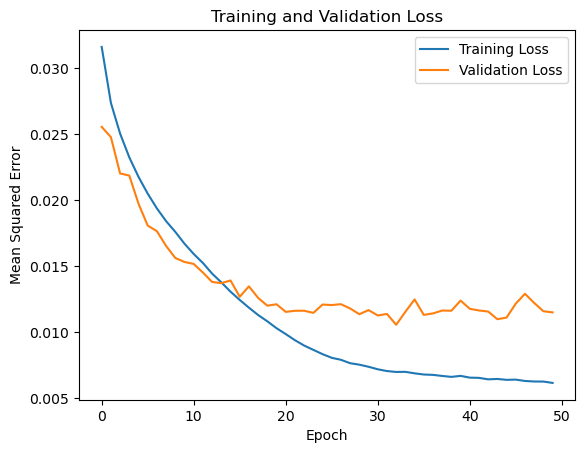

In [133]:
import matplotlib.pyplot as plt

plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [134]:
test_mse = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {test_mse}")


Mean Squared Error on test set: 0.011505432426929474


In [135]:
# Calculate RMSE from the given MSE
rmse_standardized = np.sqrt(test_mse)

# Create a dummy array with this RMSE value in the first column and zeros elsewhere
rmse_array_standardized = np.zeros((1, num_original_features))
rmse_array_standardized[0, 0] = rmse_standardized

# Now inverse transform this array
rmse_real_value_array = scaler.inverse_transform(rmse_array_standardized)

# Extract the RMSE in real value terms
rmse_real_value = rmse_real_value_array[0, 0]
rmse_real_value


18.13663913930765

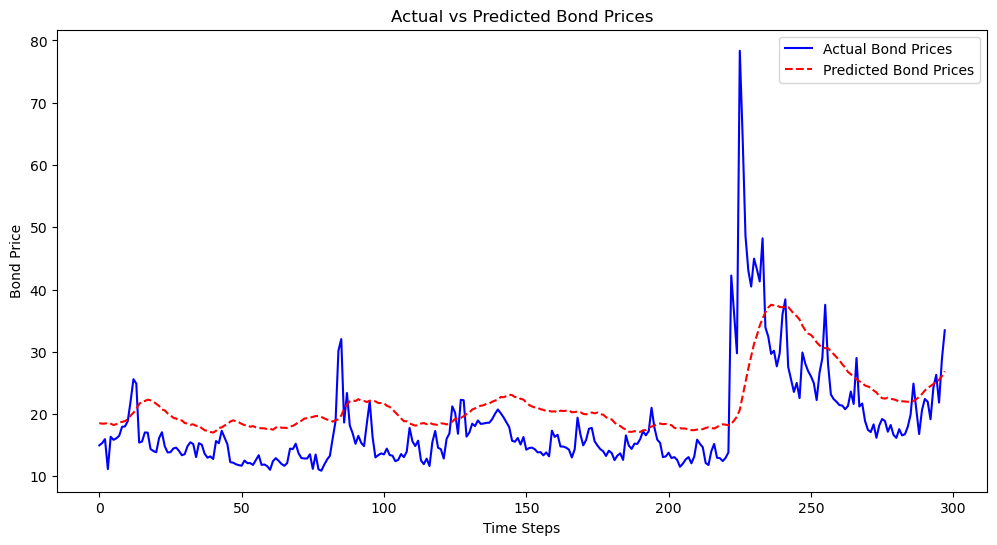

In [136]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Preparing the data for inverse transformation
# ----------------------------------------------

# Convert y_test to a 2D array for compatibility with the transformation process
y_test_2d = y_test.reshape(-1, 1)

# Number of original features minus 'Date'
num_original_features = features.shape[1] - 1

# Create a placeholder array with adjusted size
placeholder_array = np.zeros((y_test_2d.shape[0], num_original_features))

# Assign the bond prices from y_test to the first column of this placeholder array.
placeholder_array[:, 0] = y_test_2d.ravel()

# Step 2: Performing the inverse transformation
# ----------------------------------------------
actual_prices = scaler.inverse_transform(placeholder_array)[:, 0]

# Step 3: Plotting the actual vs predicted bond prices
# ----------------------------------------------------

predicted_prices = final_predicted_bond_price

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Bond Prices", color='blue')
plt.plot(predicted_prices, label="Predicted Bond Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Bond Prices")
plt.xlabel("Time Steps")
plt.ylabel("Bond Price")
plt.show()


In [137]:
mse = history.history['val_loss'][-1]  # Taking the last value from the validation loss
standard_error = np.sqrt(mse)
confidence_margin = 1.96 * standard_error

# Convert y_train to a 2D array for compatibility
y_train_2d = y_train.reshape(-1, 1)

# Create a placeholder array for y_train with adjusted size
placeholder_array_train = np.zeros((y_train_2d.shape[0], num_original_features))

# Assign the bond prices from y_train to the first column of this placeholder array
placeholder_array_train[:, 0] = y_train_2d.ravel()

# Perform the inverse transformation
actual_train_prices = scaler.inverse_transform(placeholder_array_train)[:, 0]

predicted_train_bond_price = model.predict(X_train)

# Create a dummy array for inverse transformation
temp_array_train = np.zeros((predicted_train_bond_price.shape[0], num_original_features))

# Fill the first column with `predicted_train_bond_price` values
temp_array_train[:, 0] = predicted_train_bond_price.ravel()

# Now inverse transform this array
inverse_transformed_train = scaler.inverse_transform(temp_array_train)

# Extract the bond_price predictions for the training set
final_predicted_train_bond_price = inverse_transformed_train[:, 0]


24/24 [==============================] - 0s 5ms/step


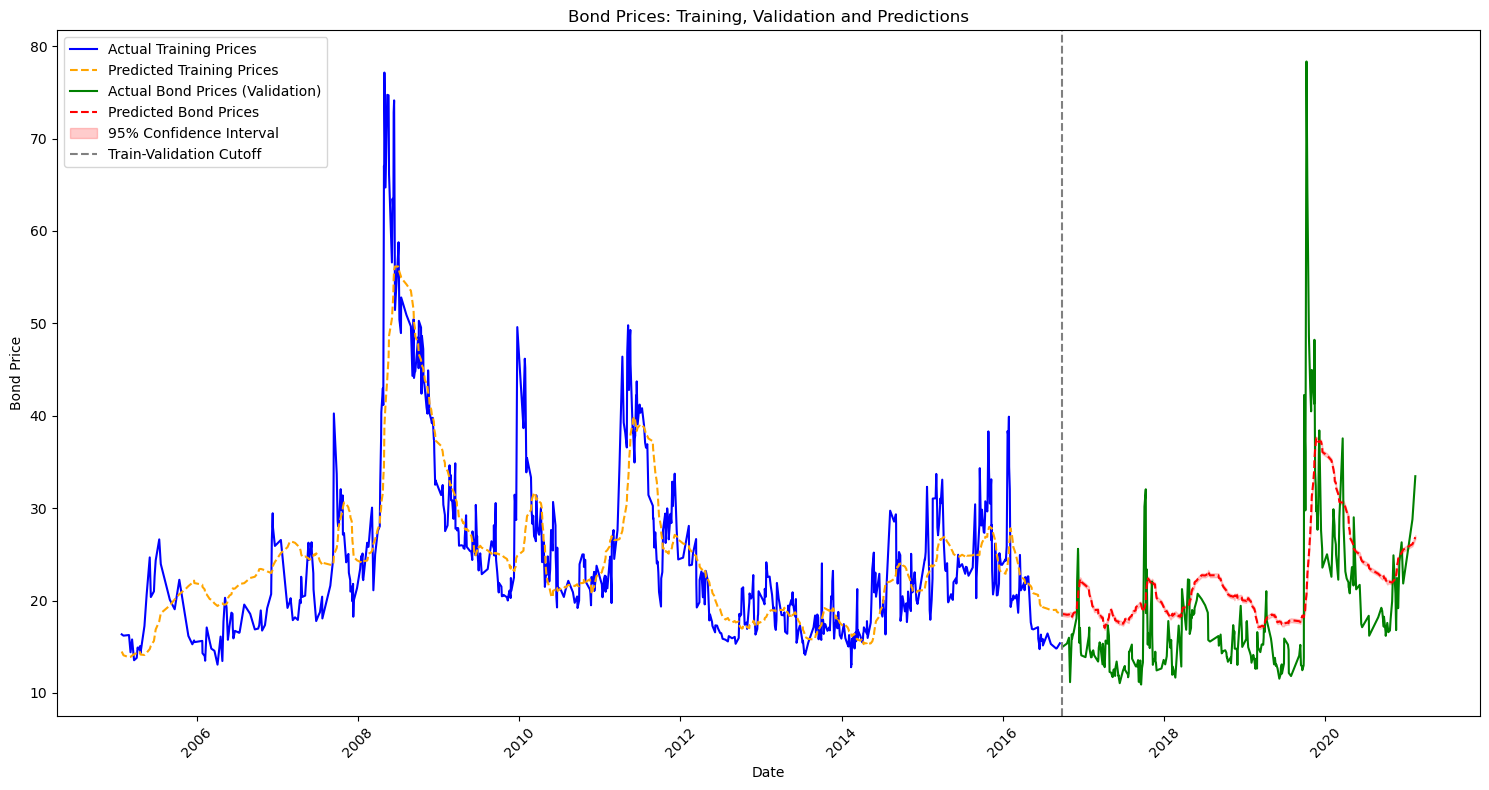

In [138]:

plt.figure(figsize=(15, 8))

# Plotting the training data with actual_train_prices
plt.plot(dates_series[:len(actual_train_prices)], actual_train_prices, label="Actual Training Prices", color='blue')

# Plotting the predicted bond prices for the training set
plt.plot(dates_series[:len(final_predicted_train_bond_price)], final_predicted_train_bond_price, label="Predicted Training Prices", color='orange', linestyle='dashed')

# Plotting the validation data (actual prices)
plt.plot(dates_series[len(actual_train_prices):len(actual_train_prices) + len(y_test)], actual_prices, label="Actual Bond Prices (Validation)", color='green')

# Plotting the predicted prices
plt.plot(dates_series[len(y_train):len(y_train) + len(y_test)], predicted_prices, label="Predicted Bond Prices", color='red', linestyle='dashed')

# Shading the 95% confidence interval
plt.fill_between(dates_series[len(y_train):len(y_train) + len(y_test)], 
                 (predicted_prices - confidence_margin), 
                 (predicted_prices + confidence_margin), 
                 color='red', 
                 alpha=0.2,
                 label='95% Confidence Interval')

# Highlighting the training-validation cutoff
plt.axvline(x=dates_series[len(y_train)], color='grey', linestyle='--', label="Train-Validation Cutoff")

plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.legend()
plt.title("Bond Prices: Training, Validation and Predictions")
plt.xlabel("Date")
plt.ylabel("Bond Price")
plt.tight_layout()
plt.show()


In [139]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping



def build_model(lstm_units=50, optimizer=None, dropout_rate=0.0, sequence_length=None, num_features=None):
    model = Sequential()
    
    model.add(LSTM(units=lstm_units, return_sequences=True, input_shape=(sequence_length, num_features)))
    model.add(Dropout(dropout_rate))
    
    model.add(LSTM(units=lstm_units))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(units=1))
    
    # Use the optimizer passed in directly
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    return model

def clone_optimizer(optimizer):
    config = optimizer.get_config()
    return type(optimizer)(**config)


In [140]:

# Define the hyperparameter grid
lstm_units_options = [30, 50, 70]
optimizers = [Adam(learning_rate=0.001), SGD(), RMSprop()]
dropout_rates = [0.1, 0.2, 0.3]

# Use grid search for hyperparameter tuning
best_val_loss = float('inf')
best_params = {}

for lstm_units in lstm_units_options:
    for optimizer in optimizers:
        for dropout_rate in dropout_rates:
            
            optimizer = clone_optimizer(optimizer)
            model = build_model(lstm_units=lstm_units, optimizer=optimizer, dropout_rate=dropout_rate, sequence_length=sequence_length, num_features=num_features)
            
            early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)
            
            history = model.fit(X_train, y_train, epochs=50, batch_size=100, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr], verbose=0)
            
            # Get the best validation loss
            val_loss = min(history.history['val_loss'])
            
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_params = {
                    'lstm_units': lstm_units,
                    'optimizer': optimizer,
                    'dropout_rate': dropout_rate
                }

print(f"Best validation loss: {best_val_loss}")
print("Best hyperparameters:", best_params)


Best validation loss: 0.006127973087131977
Best hyperparameters: {'lstm_units': 30, 'optimizer': <keras.src.optimizers.rmsprop.RMSprop object at 0x7f0e555ccc40>, 'dropout_rate': 0.1}


# With average sentiments

In [172]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract data 
# Adding the 'weighted_prob' to the model
features_2 = merged_df[['Date','Indexvalue','10_y_bond_yield', 'weighted_prob', 'vstoxx_shifted_1_day', 'day_of_week', 's10',
                       'moving_avg_sentiment_1_day','labor_prod_s1', 'unemployment_s1','Close_dax_1_day','euro_yield_1_day' ]]#, 'Close_volatility']]


features_2 = features_2[features_2['day_of_week'].notna()]

features_2['Close_dax_1_day'] = features_2['Close_dax_1_day'].fillna(method='ffill')
# features_2['Volume_dax'] = features_2['Volume_dax'].fillna(method='ffill')

# count nans
features_2.isnull().sum()
# reset index
features_2 = features_2.reset_index(drop=True)

In [173]:
features_2

,Date,Indexvalue,10_y_bond_yield,weighted_prob,vstoxx_shifted_1_day,day_of_week,s10,moving_avg_sentiment_1_day,labor_prod_s1,unemployment_s1,Close_dax_1_day,euro_yield_1_day
0,2005-01-26,13.3240,3.573076,0.553782,12.8050,Wednesday,-0.5,0.268492,0.00,0.00,4251.620117,2.795959
1,2005-02-03,12.3844,3.554661,0.527512,11.9934,Thursday,-0.5,0.285913,0.00,0.00,4214.120117,2.802277
2,2005-02-28,12.8907,3.710944,0.068567,12.8591,Monday,-0.5,0.280547,-0.77,9.29,4281.640137,2.841413
3,2005-03-07,11.7178,3.681450,-0.410220,12.5319,Monday,-0.5,0.249022,-0.77,9.29,4350.490234,2.970440
4,2005-03-14,13.3498,3.794177,0.728174,14.5708,Monday,-0.5,0.185070,-0.77,9.29,4428.089844,2.862540
...,...,...,...,...,...,...,...,...,...,...,...,...
1086,2022-01-21,24.2217,-0.079525,0.637534,31.4530,Friday,0.0,0.104626,-0.77,8.56,16020.730469,-0.549393
1087,2022-02-04,26.3008,0.195480,0.033995,23.1564,Friday,0.0,0.122252,-0.77,8.56,15603.879883,-0.500242
1088,2022-02-10,21.8414,0.281690,-0.068289,30.0547,Thursday,0.0,0.109810,-0.77,8.56,15099.559570,0.044753
1089,2022-02-17,28.7931,0.279858,0.159978,36.2245,Thursday,0.0,0.100805,-0.77,8.56,15490.440430,0.023036


In [174]:
# store the dates for later visualization 
dates_series = features['Date']

# fill the euro_yield_1_day with mean of its previous and next values
features_2['euro_yield_1_day'] = features_2['euro_yield_1_day'].fillna(method='ffill')

# make sure there are no nan values
features_2.isnull().sum()


Date                          0
Indexvalue                    0
10_y_bond_yield               0
weighted_prob                 0
vstoxx_shifted_1_day          0
day_of_week                   0
s10                           0
moving_avg_sentiment_1_day    0
labor_prod_s1                 0
unemployment_s1               0
Close_dax_1_day               0
euro_yield_1_day              0
dtype: int64

In [175]:
"""
# Lagging features by one day (for everything except 'Date' and 'Indexvalue')
for column in features_2.columns:
    if column not in ['Date', 'Indexvalue']:
        features_2[column] = features_2[column].shift(1)

# Drop the NaN row resulting from the shift
features_2 = features_2.dropna()

# Resetting index
features_2 = features_2.reset_index(drop=True)
"""

"\n# Lagging features by one day (for everything except 'Date' and 'Indexvalue')\nfor column in features_2.columns:\n    if column not in ['Date', 'Indexvalue']:\n        features_2[column] = features_2[column].shift(1)\n\n# Drop the NaN row resulting from the shift\nfeatures_2 = features_2.dropna()\n\n# Resetting index\nfeatures_2 = features_2.reset_index(drop=True)\n"

In [176]:
# 1. Handle the 'day_of_week' feature if it exists in your DataFrame
if 'day_of_week' in features_2.columns:
    dummies = pd.get_dummies(features_2['day_of_week'], drop_first=True)  # drop_first avoids multicollinearity
    features_2 = features_2.drop('day_of_week', axis=1)
    features_2 = pd.concat([features_2, dummies], axis=1)


In [177]:
# 2. Scale the data but exclude the 'Date' column

features_without_date_2 = features_2.drop(columns=['Date'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_without_date_2 = scaler.fit_transform(features_without_date_2)

In [178]:
# Convert the scaled data back to a DataFrame and re-add the 'Date' column
scaled2_df = pd.DataFrame(scaled_data_without_date_2, columns=features_without_date_2.columns)
scaled2_df['Date'] = dates_series.reset_index(drop=True)

# If you want to use scaled_df for LSTM sequences, remove the 'Date' column again
scaled_data_2 = scaled2_df.drop(columns=['Date']).values

sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data_2)):
    X.append(scaled_data_2[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y.append(scaled_data_2[i, 0])  # Target column

# Adjust the reshaping step to consider all features dynamically
num_features = scaled_data_2.shape[1] - 1  # Subtracting 1 for the target column

X, y = np.array(X), np.array(y)

X = np.reshape(X, (-1, sequence_length, num_features))

In [179]:
X.shape, y.shape

((1061, 30, 13), (1061,))

In [180]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

import numpy as np
import tensorflow as tf
import random
import os

# Set random seeds for reproducibility and consistency

# 1. Set Python's random seed
random.seed(42)

# 2. Set Numpy's random seed
np.random.seed(42)

# 3. Set TensorFlow's random seed
tf.random.set_seed(42)

# For the use case of GPU set deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Split data (70% train, 20% test)
train_size = int(0.7 * len(dates_series))
X_train_2, X_test_2 = X[:train_size], X[train_size:]
y_train_2, y_test_2 = y[:train_size], y[train_size:]

dates_train = dates_series[:train_size].reset_index(drop=True)
dates_test = dates_series[train_size:].reset_index(drop=True)

# save the dates
dates_train = dates_series[:train_size]
dates_test = dates_series[train_size:]

# Build LSTM model
model_2 = Sequential()
model_2.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, num_features))) # Use num_features instead of 4
model_2.add(LSTM(units=50))
model_2.add(Dense(units=1))
model_2.compile(optimizer='adam', loss='mean_squared_error')

# Train the model and store its history
history_2 = model_2.fit(X_train_2, y_train_2, epochs=50, batch_size=64, validation_data=(X_test_2, y_test_2))

# Access training and validation loss (can be plotted or analyzed further)
training_loss_2 = history_2.history['loss']
validation_loss_2 = history_2.history['val_loss']

# Evaluate model
predicted_bond_price_2 = model_2.predict(X_test_2)

num_original_features = features_2.shape[1] - 1 

# Create a dummy array with the same number of rows as `predicted_bond_price`
# and the same number of columns as the original data
temp_array = np.zeros((predicted_bond_price_2.shape[0], num_original_features))

# Fill the first column with `predicted_bond_price` values
temp_array[:, 0] = predicted_bond_price_2.ravel()

# Now inverse transform this array
inverse_transformed_2 = scaler.inverse_transform(temp_array)

# Extract the bond_price predictions from the first column
final_predicted_bond_price_2 = inverse_transformed_2[:, 0]

Epoch 1/50
12/12 [==============================] - 4s 78ms/step - loss: 0.0302 - val_loss: 0.0148
Epoch 2/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0151 - val_loss: 0.0136
Epoch 3/50
12/12 [==============================] - 0s 27ms/step - loss: 0.0115 - val_loss: 0.0119
Epoch 4/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0083 - val_loss: 0.0128
Epoch 5/50
12/12 [==============================] - 0s 28ms/step - loss: 0.0065 - val_loss: 0.0121
Epoch 6/50
12/12 [==============================] - 0s 25ms/step - loss: 0.0057 - val_loss: 0.0114
Epoch 7/50
12/12 [==============================] - 0s 27ms/step - loss: 0.0055 - val_loss: 0.0093
Epoch 8/50
12/12 [==============================] - 0s 26ms/step - loss: 0.0053 - val_loss: 0.0108
Epoch 9/50
12/12 [==============================] - 0s 24ms/step - loss: 0.0046 - val_loss: 0.0090
Epoch 10/50
12/12 [==============================] - 0s 23ms/step - loss: 0.0042 - val_loss: 0.0101
Epoch 11/

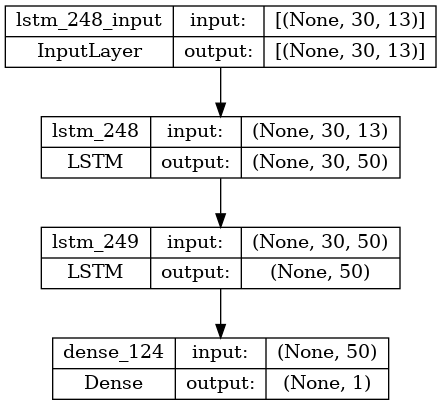

In [181]:
from keras.utils import plot_model
from tensorflow.keras.utils import plot_model

plot_model(model_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


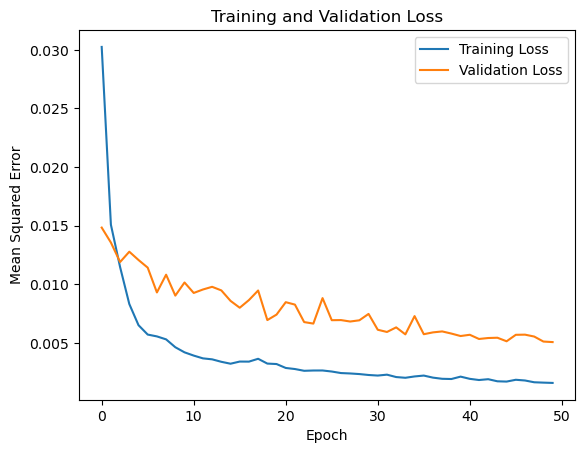

In [182]:
import matplotlib.pyplot as plt

plt.plot(training_loss_2, label='Training Loss')
plt.plot(validation_loss_2, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [183]:
test_mse_2 = model_2.evaluate(X_test_2, y_test_2, verbose=0)
print(f"Mean Squared Error on test set: {test_mse_2}")


Mean Squared Error on test set: 0.005062086973339319


In [184]:
# Calculate RMSE from the given MSE
rmse_standardized_2 = np.sqrt(test_mse_2)

# Create a dummy array with this RMSE value in the first column and zeros elsewhere
rmse_array_standardized_2 = np.zeros((1, num_original_features))
rmse_array_standardized_2[0, 0] = rmse_standardized_2

# Now inverse transform this array
rmse_real_value_array_2 = scaler.inverse_transform(rmse_array_standardized_2)

# Extract the RMSE in real value terms
rmse_real_value_2 = rmse_real_value_array_2[0, 0]
rmse_real_value_2

15.700907624822833

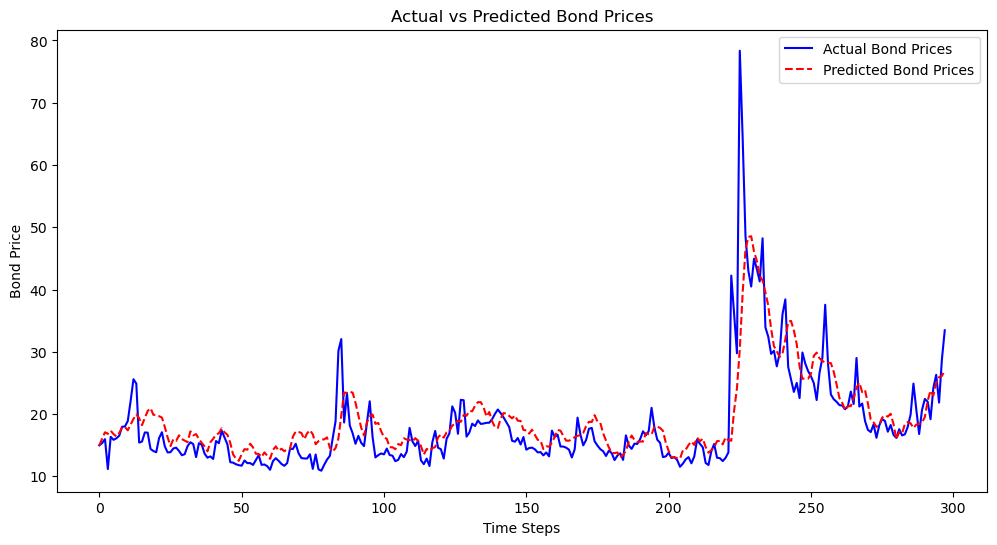

In [185]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Preparing the data for inverse transformation
# ----------------------------------------------

# Convert y_test to a 2D array for compatibility with the transformation process
y_test_2d = y_test_2.reshape(-1, 1)

# Number of original features minus 'Date'
num_original_features = features_2.shape[1] - 1

# Create a placeholder array with adjusted size
placeholder_array = np.zeros((y_test_2d.shape[0], num_original_features))

# Assign the bond prices from y_test to the first column of this placeholder array.
placeholder_array[:, 0] = y_test_2d.ravel()

# Step 2: Performing the inverse transformation
# ----------------------------------------------
actual_prices_2 = scaler.inverse_transform(placeholder_array)[:, 0]

# Step 3: Plotting the actual vs predicted bond prices
# ----------------------------------------------------

predicted_prices_2 = final_predicted_bond_price_2

plt.figure(figsize=(12, 6))
plt.plot(actual_prices_2, label="Actual Bond Prices", color='blue')
plt.plot(predicted_prices_2, label="Predicted Bond Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Bond Prices")
plt.xlabel("Time Steps")
plt.ylabel("Bond Price")
plt.show()

In [186]:
mse_2 = history_2.history['val_loss'][-1]  # Taking the last value from the validation loss
standard_error_2 = np.sqrt(mse_2)
confidence_margin_2 = 1.96 * standard_error_2

# Convert y_train to a 2D array for compatibility
y_train_2d = y_train_2.reshape(-1, 1)

# Create a placeholder array for y_train with adjusted size
placeholder_array_train = np.zeros((y_train_2d.shape[0], num_original_features))

# Assign the bond prices from y_train to the first column of this placeholder array
placeholder_array_train[:, 0] = y_train_2d.ravel()

# Perform the inverse transformation
actual_train_prices_2 = scaler.inverse_transform(placeholder_array_train)[:, 0]

predicted_train_bond_price_2 = model_2.predict(X_train_2)

# Create a dummy array for inverse transformation
temp_array_train = np.zeros((predicted_train_bond_price_2.shape[0], num_original_features))

# Fill the first column with `predicted_train_bond_price` values
temp_array_train[:, 0] = predicted_train_bond_price_2.ravel()

# Now inverse transform this array
inverse_transformed_train = scaler.inverse_transform(temp_array_train)

# Extract the bond_price predictions for the training set
final_predicted_train_bond_price_2 = inverse_transformed_train[:, 0]

24/24 [==============================] - 0s 5ms/step


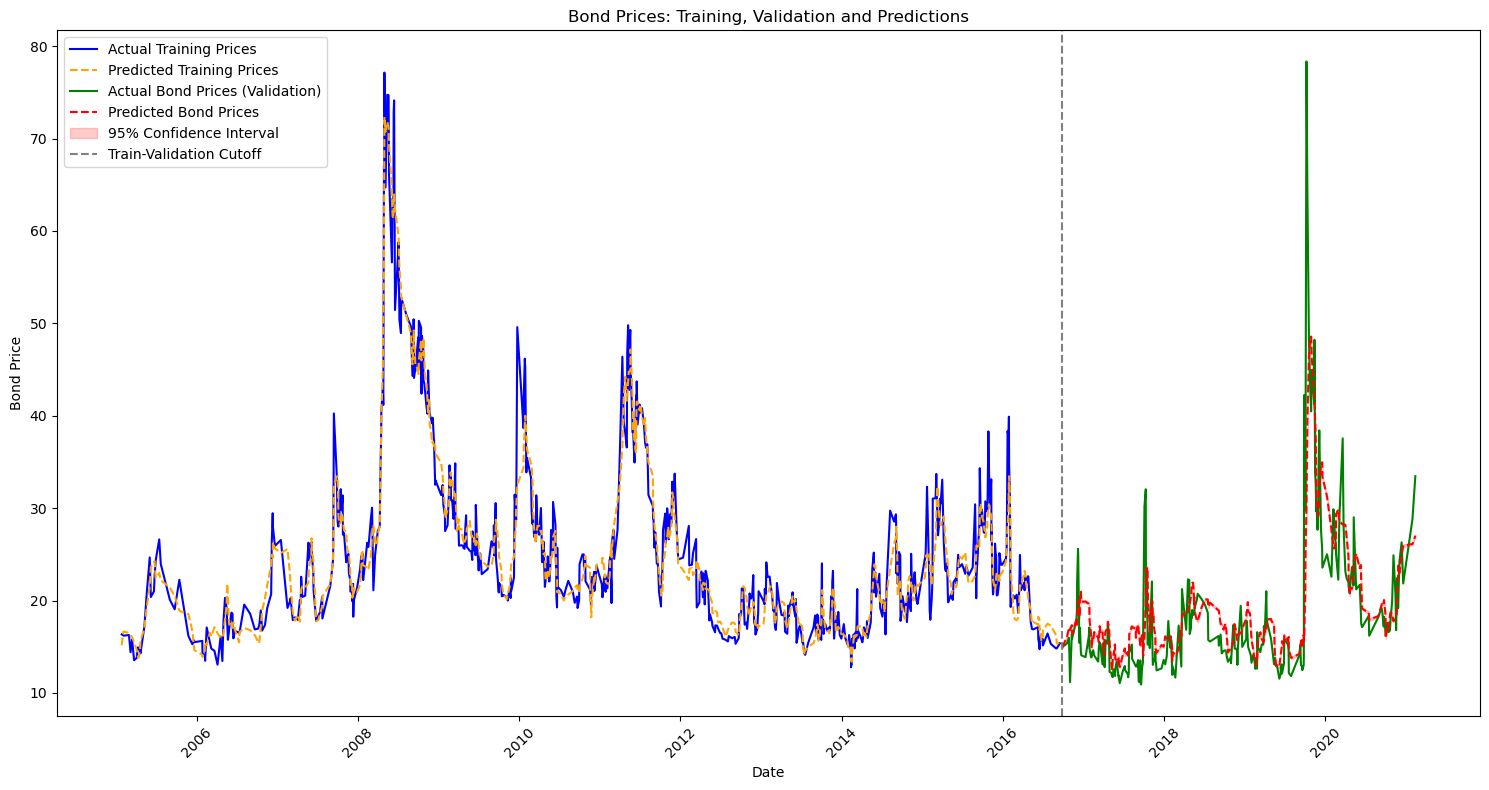

In [187]:
plt.figure(figsize=(15, 8))

# Plotting the training data with actual_train_prices
plt.plot(dates_series[:len(actual_train_prices_2)], actual_train_prices_2, label="Actual Training Prices", color='blue')

# Plotting the predicted bond prices for the training set
plt.plot(dates_series[:len(final_predicted_train_bond_price_2)], final_predicted_train_bond_price_2, label="Predicted Training Prices", color='orange', linestyle='dashed')

# Plotting the validation data (actual prices)
plt.plot(dates_series[len(actual_train_prices_2):len(actual_train_prices_2) + len(y_test_2)], actual_prices_2, label="Actual Bond Prices (Validation)", color='green')

# Plotting the predicted prices
plt.plot(dates_series[len(y_train_2):len(y_train_2) + len(y_test_2)], predicted_prices_2, label="Predicted Bond Prices", color='red', linestyle='dashed')

# Shading the 95% confidence interval
plt.fill_between(dates_series[len(y_train_2):len(y_train_2) + len(y_test_2)], 
                 (predicted_prices_2 - confidence_margin_2), 
                 (predicted_prices_2 + confidence_margin_2), 
                 color='red', 
                 alpha=0.2,
                 label='95% Confidence Interval')

# Highlighting the training-validation cutoff
plt.axvline(x=dates_series[len(y_train_2)], color='grey', linestyle='--', label="Train-Validation Cutoff")

plt.xticks(rotation=45)  # Rotating x-axis labels for better readability
plt.legend()
plt.title("Bond Prices: Training, Validation and Predictions")
plt.xlabel("Date")
plt.ylabel("Bond Price")
plt.tight_layout()
plt.show()

In [188]:
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Define the hyperparameter grid
lstm_units_options = [30, 50, 70]
optimizers = [Adam(learning_rate=0.001), SGD(), RMSprop()]
dropout_rates = [0.1, 0.2, 0.3]

# Use grid search for hyperparameter tuning
best_val_loss_2 = float('inf')
best_params_2 = {}

for lstm_units in lstm_units_options:
    for optimizer in optimizers:
        for dropout_rate in dropout_rates:
            
            optimizer = clone_optimizer(optimizer)
            model_2 = build_model(lstm_units=lstm_units, optimizer=optimizer, dropout_rate=dropout_rate, sequence_length=sequence_length, num_features=num_features)
            
            early_stopping = EarlyStopping(patience=10, restore_best_weights=True)
            reduce_lr = ReduceLROnPlateau(factor=0.5, patience=5)
            
            history_2 = model_2.fit(X_train_2, y_train_2, epochs=50, batch_size=100, validation_data=(X_test_2, y_test_2), callbacks=[early_stopping, reduce_lr], verbose=0)
            
            # Get the best validation loss
            val_loss_2 = min(history_2.history['val_loss'])
            
            if val_loss_2 < best_val_loss_2:
                best_val_loss_2 = val_loss_2
                best_params_2 = {
                    'lstm_units': lstm_units,
                    'optimizer': optimizer,
                    'dropout_rate': dropout_rate
                }

print(f"Best validation loss: {best_val_loss_2}")
print("Best hyperparameters:", best_params_2)


Best validation loss: 0.006335958372801542
Best hyperparameters: {'lstm_units': 70, 'optimizer': <keras.src.optimizers.rmsprop.RMSprop object at 0x7f0e8e675bb0>, 'dropout_rate': 0.1}


# model comparison tables and visualizations

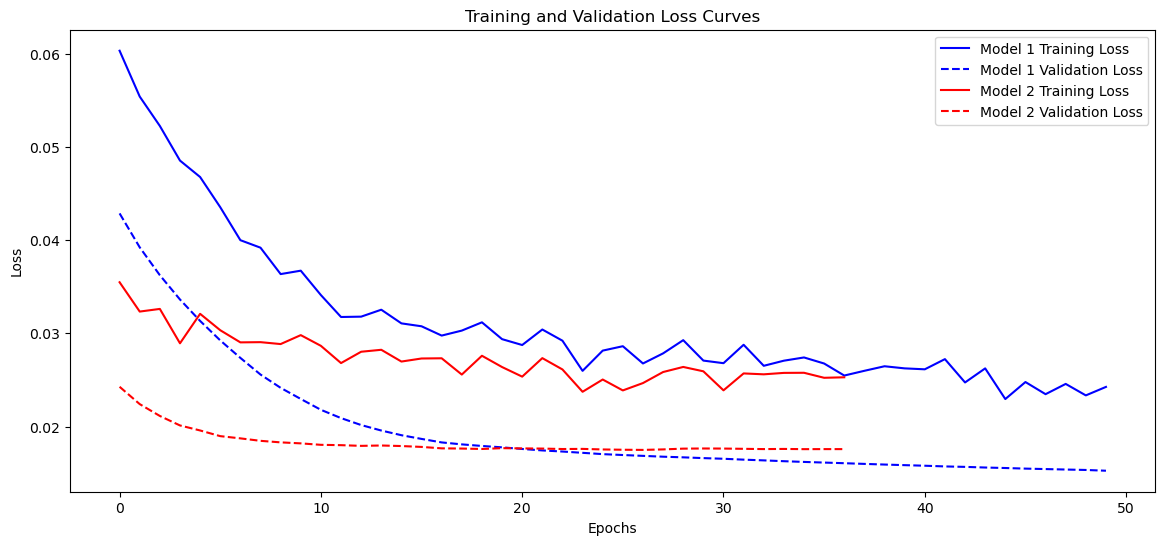

In [189]:

import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(history.history['loss'], label='Model 1 Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Model 1 Validation Loss', color='blue', linestyle='dashed')
plt.plot(history_2.history['loss'], label='Model 2 Training Loss', color='red')
plt.plot(history_2.history['val_loss'], label='Model 2 Validation Loss', color='red', linestyle='dashed')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Curves')
plt.show()



In [190]:
from sklearn.metrics import mean_absolute_error

mae_1 = mean_absolute_error(y_test, model.predict(X_test))
mae_2 = mean_absolute_error(y_test_2, model_2.predict(X_test_2))


10/10 [==============================] - 1s 6ms/step


In [191]:
mae_1, mae_2

(0.08226622872131376, 0.07798831937403215)

In [197]:
X_test.shape

(298, 30, 11)

In [198]:
residuals_1 = y_test - model.predict(X_test).ravel()
residuals_2 = y_test_2 - model_2.predict(X_test_2).ravel()

 1/10 [==>...........................] - ETA: 0s

10/10 [==============================] - 0s 7ms/step


In [199]:
residuals_1.shape, residuals_2.shape

((298,), (298,))

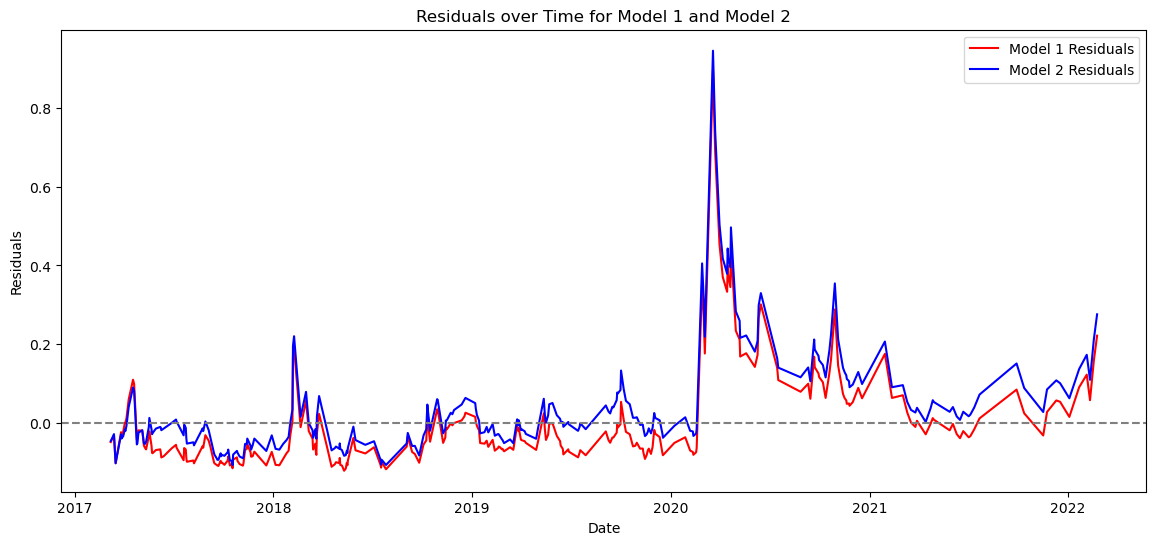

In [203]:
dates_test = dates_test[-298:]  # take the last 298 dates
plt.figure(figsize=(14, 6))

# Plot residuals for Model 1
plt.plot(dates_test, residuals_1, label='Model 1 Residuals', color='red')

# Plot residuals for Model 2
plt.plot(dates_test, residuals_2, label='Model 2 Residuals', color='blue')

# Add a horizontal line at y=0
plt.axhline(y=0, color='grey', linestyle='--')

# Labeling and titles
plt.xlabel('Date')
plt.ylabel('Residuals')
plt.legend()
plt.title('Residuals over Time for Model 1 and Model 2')

plt.show()


In [205]:
params_1 = model.count_params()
params_2 = model_2.count_params()
params_1 , params_2

(62511, 63071)

In [208]:
import pandas as pd

# Quantitative Metrics
data = {
    'Metric/Aspect': [
        'MSE', 
        'RMSE', 
        'MAE', 
        'Best Validation Loss', 
        'Number of LSTM Units', 
        'Dropout Rate', 
        'Optimizer Type', 
        'Number of Training Epochs',
        'Number of Parameters'
    ],
    'Model 1': [
        test_mse, 
        rmse_real_value, 
        mae_1, 
        min(history.history['val_loss']), 
        model.layers[0].units,  # Assuming first LSTM layer for units
        "0.1",
        model.optimizer.get_config()['name'],
        len(history.history['loss']),
        params_1
    ],
    'Model 2': [
        test_mse_2, 
        rmse_real_value_2, 
        mae_2, 
        min(history_2.history['val_loss']), 
        model_2.layers[0].units, 
        "0.3",
        model_2.optimizer.get_config()['name'],
        len(history_2.history['loss']),
        params_2
    ]
}

# Create DataFrame
model_comparison = pd.DataFrame(data)

print(model_comparison)



               Metric/Aspect    Model 1    Model 2
0                        MSE   0.011505   0.005062
1                       RMSE  18.136639  15.700908
2                        MAE   0.082266   0.077988
3       Best Validation Loss   0.015257   0.017492
4       Number of LSTM Units         70         70
5               Dropout Rate        0.1        0.3
6             Optimizer Type    RMSprop    RMSprop
7  Number of Training Epochs         50         37
8       Number of Parameters      62511      63071


In [ ]:
latex_code = model_comparison.to_latex(index=False)
latex_code

'\\begin{tabular}{lll}\n\\toprule\nMetric/Aspect & Model 1 & Model 2 \\\\\n\\midrule\nMSE & 0.005062 & 0.008167 \\\\\nRMSE & 15.700908 & 16.997306 \\\\\nMAE & 0.077988 & 0.073336 \\\\\nBest Validation Loss & 0.017492 & 0.011456 \\\\\nNumber of LSTM Units & 70 & 70 \\\\\nDropout Rate & 0.1 & 0.3 \\\\\nOptimizer Type & RMSprop & RMSprop \\\\\nNumber of Training Epochs & 37 & 50 \\\\\n\\bottomrule\n\\end{tabular}\n'

# Attention mechanism in LSTM without sentiments

In [209]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract data 
# taking out the 'weighted_prob' from the model
features_3 = merged_df[['Date','Indexvalue','10_y_bond_yield', 'vstoxx_shifted_1_day', 'day_of_week', 's10',
                       'labor_prod_s1', 'unemployment_s1','Close_dax_1_day','euro_yield_1_day' ]]#, 'Close_volatility']]



features_3 = features_3[features_3['day_of_week'].notna()]

features_3['Close_dax_1_day'] = features_3['Close_dax_1_day'].fillna(method='ffill')
# features_2['Volume_dax'] = features_2['Volume_dax'].fillna(method='ffill')

# count nans
features_3.isnull().sum()
# reset index
features_3 = features_3.reset_index(drop=True)

In [229]:
# store the dates for later visualization 
dates_series = features_3['Date']

# fill the euro_yield_1_day with mean of its previous and next values
features_3['euro_yield_1_day'] = features_3['euro_yield_1_day'].fillna(method='ffill')

# make sure there are no nan values
features_3.isnull().sum()

Date                    0
Indexvalue              0
10_y_bond_yield         0
vstoxx_shifted_1_day    0
s10                     0
labor_prod_s1           0
unemployment_s1         0
Close_dax_1_day         0
euro_yield_1_day        0
Monday                  0
Thursday                0
Tuesday                 0
Wednesday               0
dtype: int64

In [230]:
# Lagging features by one day (for everything except 'Date' and 'Indexvalue')
for column in features_3.columns:
    if column not in ['Date', 'Indexvalue']:
        features_3[column] = features_3[column].shift(1)

# Drop the NaN row resulting from the shift
features_3 = features_3.dropna()

# Resetting index
features_3 = features_3.reset_index(drop=True)

In [231]:
# 1. Handle the 'day_of_week' feature if it exists in your DataFrame
if 'day_of_week' in features_3.columns:
    dummies = pd.get_dummies(features_3['day_of_week'], drop_first=True)  # drop_first avoids multicollinearity
    features_3 = features_3.drop('day_of_week', axis=1)
    features_3 = pd.concat([features_3, dummies], axis=1)

# 2. Scale the data but exclude the 'Date' column

features_without_date_3 = features_3.drop(columns=['Date'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_without_date_3 = scaler.fit_transform(features_without_date_3)

In [232]:
# Convert the scaled data back to a DataFrame and re-add the 'Date' column
scaled3_df = pd.DataFrame(scaled_data_without_date_3, columns=features_without_date_3.columns)
scaled3_df['Date'] = dates_series.reset_index(drop=True)

# If you want to use scaled_df for LSTM sequences, remove the 'Date' column again
scaled_data_3 = scaled3_df.drop(columns=['Date']).values

sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data_3)):
    X.append(scaled_data_3[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y.append(scaled_data_3[i, 0])  # Target column

# Adjust the reshaping step to consider all features dynamically
num_features = scaled_data_3.shape[1] - 1  # Subtracting 1 for the target column

X, y = np.array(X), np.array(y)

X = np.reshape(X, (-1, sequence_length, num_features))

In [233]:
features_3

,Date,Indexvalue,10_y_bond_yield,vstoxx_shifted_1_day,s10,labor_prod_s1,unemployment_s1,Close_dax_1_day,euro_yield_1_day,Monday,Thursday,Tuesday,Wednesday
0,2005-02-28,12.8907,3.573076,12.8050,-0.5,0.00,0.00,4251.620117,2.795959,False,False,False,True
1,2005-03-07,11.7178,3.554661,11.9934,-0.5,0.00,0.00,4214.120117,2.802277,False,True,False,False
2,2005-03-14,13.3498,3.710944,12.8591,-0.5,-0.77,9.29,4281.640137,2.841413,True,False,False,False
3,2005-03-23,13.4667,3.681450,12.5319,-0.5,-0.77,9.29,4350.490234,2.970440,True,False,False,False
4,2005-04-04,13.6745,3.794177,14.5708,-0.5,-0.77,9.29,4428.089844,2.862540,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084,2022-01-21,24.2217,-0.360455,22.8332,0.0,-0.77,8.56,15623.309570,-0.675031,False,False,False,False
1085,2022-02-04,26.3008,-0.123137,17.7553,0.0,-0.77,8.56,15531.690430,-0.705494,True,False,False,False
1086,2022-02-10,21.8414,-0.079525,31.4530,0.0,-0.77,8.56,16020.730469,-0.549393,False,False,False,False
1087,2022-02-17,28.7931,0.195480,23.1564,0.0,-0.77,8.56,15603.879883,-0.500242,False,False,False,False


In [234]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

import numpy as np
import tensorflow as tf
import random
import os

# Set random seeds for reproducibility and consistency

# 1. Set Python's random seed
random.seed(42)

# 2. Set Numpy's random seed
np.random.seed(42)

# 3. Set TensorFlow's random seed
tf.random.set_seed(42)

# For the use case of GPU set deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Split data (70% train, 20% test)
train_size = int(0.7 * len(dates_series))
X_train_3, X_test_3 = X[:train_size], X[train_size:]
y_train_3, y_test_3 = y[:train_size], y[train_size:]

dates_train = dates_series[:train_size].reset_index(drop=True)
dates_test = dates_series[train_size:].reset_index(drop=True)

# save the dates
dates_train = dates_series[:train_size]
dates_test = dates_series[train_size:]


In [239]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Attention, Concatenate
from keras.optimizers import Adam

# Given parameters
sequence_length = 30  
num_features = 12
opt = Adam(learning_rate=0.00001)

# Encoder
encoder_inputs = Input(shape=(None, num_features-1))  # set the sequence_length to None
encoder_lstm = LSTM(50, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, num_features-1 ))  # set the sequence_length to None
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Attention layer
attention = Attention()
attention_output = attention([encoder_outputs, decoder_outputs])

# Concatenating the output of the Attention layer with the decoder's output
merged = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Final dense layer
output_layer = Dense(1, activation='linear')
outputs = output_layer(merged)

# Define the model
model_3 = Model([encoder_inputs, decoder_inputs], outputs)
model_3.compile(optimizer=opt, loss='mean_squared_error')

# Train the model
history_3 = model_3.fit([X_train_3, X_train_3], y_train_3, epochs=50, batch_size=64, validation_data=([X_test_3, X_test_3], y_test_3))

# Access training and validation loss (can be plotted or analyzed further)
training_loss_3 = history_3.history['loss']
validation_loss_3 = history_3.history['val_loss']



Epoch 1/50


2023-09-26 18:03:59.195019: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1190 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 524288 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


12/12 [==============================] - 4s 82ms/step - loss: 0.0932 - val_loss: 0.1084
Epoch 2/50
 1/12 [=>............................] - ETA: 0s - loss: 0.0655

2023-09-26 18:04:00.582840: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1190 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 524288 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


12/12 [==============================] - 0s 37ms/step - loss: 0.0880 - val_loss: 0.1034
Epoch 3/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0832 - val_loss: 0.0985
Epoch 4/50
12/12 [==============================] - 0s 42ms/step - loss: 0.0788 - val_loss: 0.0939
Epoch 5/50
12/12 [==============================] - 0s 40ms/step - loss: 0.0744 - val_loss: 0.0895
Epoch 6/50
12/12 [==============================] - 1s 47ms/step - loss: 0.0706 - val_loss: 0.0853
Epoch 7/50
12/12 [==============================] - 0s 38ms/step - loss: 0.0668 - val_loss: 0.0813
Epoch 8/50
12/12 [==============================] - 0s 41ms/step - loss: 0.0634 - val_loss: 0.0776
Epoch 9/50
12/12 [==============================] - 0s 33ms/step - loss: 0.0603 - val_loss: 0.0740
Epoch 10/50
12/12 [==============================] - 0s 34ms/step - loss: 0.0572 - val_loss: 0.0706
Epoch 11/50
12/12 [==============================] - 0s 38ms/step - loss: 0.0543 - val_loss: 0.0674
Epoch 12/50
12/12 [

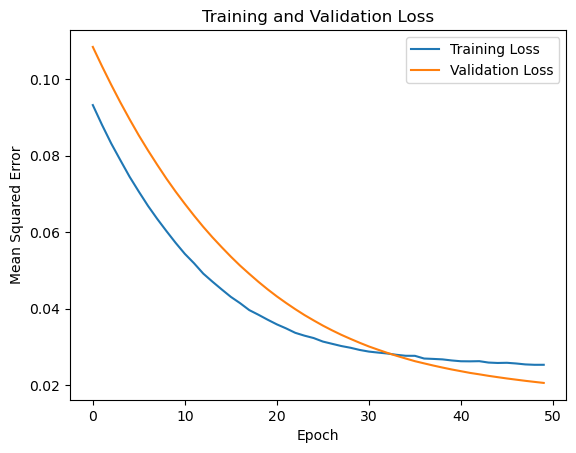

In [240]:
import matplotlib.pyplot as plt

plt.plot(training_loss_3, label='Training Loss')
plt.plot(validation_loss_3, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [243]:
# Evaluate model
predicted_bond_price_3 = model_3.predict([X_test_3, X_test_3])

# Extract the final predictions for each sequence
final_predictions = predicted_bond_price_3[:, -1, 0]

num_original_features = features_3.shape[1] - 1 

# Create a dummy array with the same number of rows as `predicted_bond_price`
# and the same number of columns as the original data
temp_array = np.zeros((final_predictions.shape[0], num_original_features))

# Fill the first column with `predicted_bond_price` values
temp_array[:, 0] = final_predictions

# Now inverse transform this array
inverse_transformed_3 = scaler.inverse_transform(temp_array)

# Extract the bond_price predictions from the first column
final_predicted_bond_price_3 = inverse_transformed_3[:, 0]



10/10 [==============================] - 1s 7ms/step


2023-09-26 18:04:50.501671: W tensorflow/core/grappler/costs/op_level_cost_estimator.cc:693] Error in PredictCost() for the op: op: "Softmax" attr { key: "T" value { type: DT_FLOAT } } inputs { dtype: DT_FLOAT shape { unknown_rank: true } } device { type: "CPU" vendor: "GenuineIntel" model: "110" frequency: 1190 num_cores: 8 environment { key: "cpu_instruction_set" value: "AVX SSE, SSE2, SSE3, SSSE3, SSE4.1, SSE4.2" } environment { key: "eigen" value: "3.4.90" } l1_cache_size: 49152 l2_cache_size: 524288 l3_cache_size: 6291456 memory_size: 268435456 } outputs { dtype: DT_FLOAT shape { unknown_rank: true } }


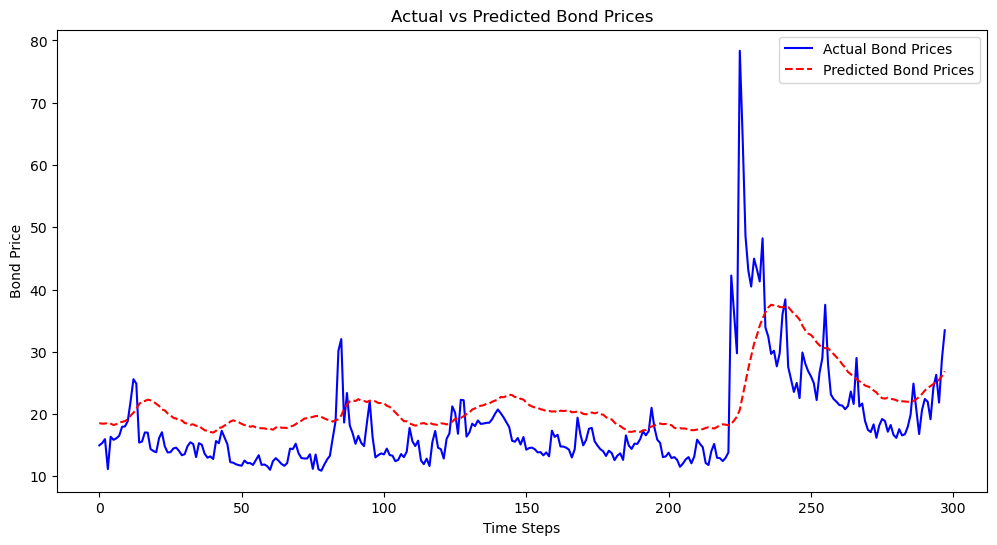

In [245]:
predicted_prices = final_predicted_bond_price

plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label="Actual Bond Prices", color='blue')
plt.plot(predicted_prices, label="Predicted Bond Prices", color='red', linestyle='dashed')
plt.legend()
plt.title("Actual vs Predicted Bond Prices")
plt.xlabel("Time Steps")
plt.ylabel("Bond Price")
plt.show()

In [244]:
test_mse_3 = model_3.evaluate((X_test_3, X_test_3), y_test_3, verbose=0)
print(f"Mean Squared Error on test set: {test_mse_3}")

Mean Squared Error on test set: 0.020252805203199387


# Attention based LSTM with speech sentiments

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Extract data 

features_4 = merged_df[['Date','Indexvalue','weighted_prob', '10_y_bond_yield', 'vstoxx_shifted_1_day', 'day_of_week', 's10',
                       'moving_avg_sentiment_1_day','labor_prod_s1', 'unemployment_s1','Close_dax_1_day','euro_yield_1_day' ]]#, 'Close_volatility']]



features_4 = features_4[features_4['day_of_week'].notna()]

features_4['Close_dax_1_day'] = features_4['Close_dax_1_day'].fillna(method='ffill')
# features_2['Volume_dax'] = features_2['Volume_dax'].fillna(method='ffill')

# count nans
features_4.isnull().sum()
# reset index
features_4 = features_4.reset_index(drop=True)

In [ ]:
# store the dates for later visualization 
dates_series = features['Date']

# fill the euro_yield_1_day with mean of its previous and next values
features_4['euro_yield_1_day'] = features_4['euro_yield_1_day'].fillna(method='ffill')

# make sure there are no nan values
features_4.isnull().sum()

In [ ]:
# 1. Handle the 'day_of_week' feature if it exists in your DataFrame
if 'day_of_week' in features_4.columns:
    dummies = pd.get_dummies(features_4['day_of_week'], drop_first=True)  # drop_first avoids multicollinearity
    features_4 = features_4.drop('day_of_week', axis=1)
    features_4 = pd.concat([features_4, dummies], axis=1)

# 2. Scale the data but exclude the 'Date' column

features_without_date_4 = features_4.drop(columns=['Date'])

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data_without_date_4 = scaler.fit_transform(features_without_date_4)

In [ ]:
# Convert the scaled data back to a DataFrame and re-add the 'Date' column
scaled4_df = pd.DataFrame(scaled_data_without_date_4, columns=features_without_date_4.columns)
scaled4_df['Date'] = dates_series.reset_index(drop=True)

# If you want to use scaled_df for LSTM sequences, remove the 'Date' column again
scaled_data_4 = scaled4_df.drop(columns=['Date']).values

sequence_length = 30
X = []
y = []

for i in range(sequence_length, len(scaled_data_4)):
    X.append(scaled_data_4[i-sequence_length:i, 1:])  # All columns except the target (assuming the target is in the 0th column)
    y.append(scaled_data_4[i, 0])  # Target column

# Adjust the reshaping step to consider all features dynamically
num_features = scaled_data_4.shape[1] - 1  # Subtracting 1 for the target column

X, y = np.array(X), np.array(y)

X = np.reshape(X, (-1, sequence_length, num_features))

In [ ]:
# Import necessary libraries
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

import numpy as np
import tensorflow as tf
import random
import os

# Set random seeds for reproducibility and consistency

# 1. Set Python's random seed
random.seed(42)

# 2. Set Numpy's random seed
np.random.seed(42)

# 3. Set TensorFlow's random seed
tf.random.set_seed(42)

# For the use case of GPU set deterministic operations
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Split data (70% train, 20% test)
train_size = int(0.7 * len(dates_series))
X_train_4, X_test_4 = X[:train_size], X[train_size:]
y_train_4, y_test_4 = y[:train_size], y[train_size:]

dates_train = dates_series[:train_size].reset_index(drop=True)
dates_test = dates_series[train_size:].reset_index(drop=True)

# save the dates
dates_train = dates_series[:train_size]
dates_test = dates_series[train_size:]

In [ ]:
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Attention, Concatenate
from keras.optimizers import Adam

# Given parameters
sequence_length = 30  # or any other value you'd like to set
num_features = 12
opt = Adam(learning_rate=0.00001)

# Encoder
encoder_inputs = Input(shape=(None, num_features))  # set the sequence_length to None
encoder_lstm = LSTM(50, return_sequences=True, return_state=True, dropout=0.15, recurrent_dropout=0.15)
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(None, num_features))  # set the sequence_length to None
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)

# Attention layer
attention = Attention()
attention_output = attention([encoder_outputs, decoder_outputs])

# Concatenating the output of the Attention layer with the decoder's output
merged = Concatenate(axis=-1)([decoder_outputs, attention_output])

# Final dense layer
output_layer = Dense(1, activation='linear')
outputs = output_layer(merged)

# Define the model
model_4 = Model([encoder_inputs, decoder_inputs], outputs)
model_4.compile(optimizer=opt, loss='mean_squared_error')

# Train the model
history_4 = model_4.fit([X_train_4, X_train_4], y_train_4, epochs=50, batch_size=64, validation_data=([X_test_4, X_test_4], y_test_4))

# Access training and validation loss (can be plotted or analyzed further)
training_loss_4 = history_4.history['loss']
validation_loss_4 = history_4.history['val_loss']

In [ ]:
import matplotlib.pyplot as plt

plt.plot(training_loss_4, label='Training Loss')
plt.plot(validation_loss_4, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [ ]:
test_mse_3 = model_3.evaluate((X_test_3, X_test_3), y_test_3, verbose=0)
print(f"Mean Squared Error on test set: {test_mse_3}")